# TopoQuery: Explainable Query Recommendations via Persistent Homology

**Pipeline Steps:**
1. Create Palmer Penguins database
2. Generate 31 SQL queries  
3. Extract 41-dimensional features
4. Compute persistent homology
5. Generate recommendations
6. Visualize results


## Step 1: Create Database


In [21]:
import sqlite3
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import random
import os

os.makedirs('data', exist_ok=True)

# Load Palmer Penguins
penguins = sns.load_dataset('penguins').dropna()

# Add metadata
base_date = datetime(2007, 11, 1)
researchers = ['Dr. Gorman', 'Dr. Williams', 'Dr. Fraser', 'Dr. Palmer']
penguins['observation_date'] = [(base_date + timedelta(days=random.randint(0, 1095))).strftime('%Y-%m-%d') for _ in range(len(penguins))]
penguins['researcher'] = [random.choice(researchers) for _ in range(len(penguins))]

# Create database
conn = sqlite3.connect('data/penguins.db')
penguins.to_sql('penguins', conn, if_exists='replace', index=False)
conn.close()

print(f"✓ Loaded {len(penguins)} observations")


✓ Loaded 333 observations


## Step 2: Generate Sample Queries

Create diverse SQL queries representing different analytical patterns.

In [22]:
import json
import os

def generate_sample_queries():
    """Generate diverse SQL queries representing different analytical patterns"""
    
    queries = [
        # Simple species filters
        {
            'sql': 'SELECT * FROM penguins WHERE species = "Adelie"',
            'description': 'Get all Adelie penguin observations',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 09:00:00'
        },
        {
            'sql': 'SELECT * FROM penguins WHERE species = "Chinstrap"',
            'description': 'Get all Chinstrap penguin observations',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 09:05:00'
        },
        {
            'sql': 'SELECT * FROM penguins WHERE species = "Gentoo"',
            'description': 'Get all Gentoo penguin observations',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 10:00:00'
        },
        
        # Island-based queries
        {
            'sql': 'SELECT * FROM penguins WHERE island = "Torgersen"',
            'description': 'Get all observations from Torgersen island',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 08:00:00'
        },
        {
            'sql': 'SELECT * FROM penguins WHERE island = "Biscoe"',
            'description': 'Get all observations from Biscoe island',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 08:10:00'
        },
        
        # Aggregations by species
        {
            'sql': 'SELECT species, AVG(bill_length_mm) FROM penguins GROUP BY species',
            'description': 'Average bill length by species',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 09:15:00'
        },
        {
            'sql': 'SELECT species, AVG(bill_depth_mm) FROM penguins GROUP BY species',
            'description': 'Average bill depth by species',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 09:20:00'
        },
        {
            'sql': 'SELECT species, AVG(flipper_length_mm) FROM penguins GROUP BY species',
            'description': 'Average flipper length by species',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 10:10:00'
        },
        {
            'sql': 'SELECT species, AVG(body_mass_g) FROM penguins GROUP BY species',
            'description': 'Average body mass by species',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 10:15:00'
        },
        
        # Count aggregations
        {
            'sql': 'SELECT species, COUNT(*) FROM penguins GROUP BY species',
            'description': 'Count observations per species',
            'user': 'Dr. Palmer',
            'timestamp': '2024-01-17 11:00:00'
        },
        {
            'sql': 'SELECT island, COUNT(*) FROM penguins GROUP BY island',
            'description': 'Count observations per island',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 08:30:00'
        },
        {
            'sql': 'SELECT sex, COUNT(*) FROM penguins GROUP BY sex',
            'description': 'Count observations by sex',
            'user': 'Dr. Palmer',
            'timestamp': '2024-01-17 11:10:00'
        },
        
        # Multi-dimensional aggregations
        {
            'sql': 'SELECT species, island, COUNT(*) FROM penguins GROUP BY species, island',
            'description': 'Species distribution across islands',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 09:00:00'
        },
        {
            'sql': 'SELECT species, sex, AVG(body_mass_g) FROM penguins GROUP BY species, sex',
            'description': 'Average body mass by species and sex',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 10:30:00'
        },
        {
            'sql': 'SELECT island, species, AVG(bill_length_mm) FROM penguins GROUP BY island, species',
            'description': 'Average bill length by island and species',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 09:15:00'
        },
        
        # JOIN queries with metadata
        {
            'sql': '''SELECT p.species, s.scientific_name, AVG(p.body_mass_g) 
                     FROM penguins p JOIN species_info s ON p.species = s.species 
                     GROUP BY p.species''',
            'description': 'Average body mass with scientific names',
            'user': 'Dr. Palmer',
            'timestamp': '2024-01-17 11:30:00'
        },
        {
            'sql': '''SELECT p.island, i.area_km2, COUNT(*) 
                     FROM penguins p JOIN island_info i ON p.island = i.island 
                     GROUP BY p.island''',
            'description': 'Observation counts with island area',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 09:30:00'
        },
        {
            'sql': '''SELECT p.species, s.habitat, AVG(p.flipper_length_mm) 
                     FROM penguins p JOIN species_info s ON p.species = s.species 
                     GROUP BY p.species''',
            'description': 'Average flipper length with habitat info',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 11:00:00'
        },
        
        # Filtered aggregations
        {
            'sql': 'SELECT AVG(bill_length_mm) FROM penguins WHERE body_mass_g > 4000',
            'description': 'Average bill length for heavy penguins',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 09:30:00'
        },
        {
            'sql': 'SELECT AVG(flipper_length_mm) FROM penguins WHERE bill_depth_mm > 18',
            'description': 'Average flipper length for deep bills',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 10:45:00'
        },
        {
            'sql': '''SELECT species, AVG(bill_length_mm) 
                     FROM penguins 
                     WHERE body_mass_g > 3500 
                     GROUP BY species''',
            'description': 'Average bill length by species for larger penguins',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 09:45:00'
        },
        
        # Complex filtering
        {
            'sql': '''SELECT * FROM penguins 
                     WHERE bill_length_mm > 45 AND flipper_length_mm > 200''',
            'description': 'Find large penguins (long bill and flipper)',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 11:15:00'
        },
        {
            'sql': '''SELECT species, COUNT(*) FROM penguins 
                     WHERE body_mass_g BETWEEN 3000 AND 4000 
                     GROUP BY species''',
            'description': 'Count medium-sized penguins by species',
            'user': 'Dr. Palmer',
            'timestamp': '2024-01-17 11:45:00'
        },
        
        # Statistical queries
        {
            'sql': 'SELECT species, MAX(body_mass_g), MIN(body_mass_g) FROM penguins GROUP BY species',
            'description': 'Body mass range by species',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 10:20:00'
        },
        {
            'sql': 'SELECT island, MAX(bill_length_mm), MIN(bill_length_mm) FROM penguins GROUP BY island',
            'description': 'Bill length range by island',
            'user': 'Dr. Fraser',
            'timestamp': '2024-01-16 09:45:00'
        },
        
        # Researcher queries
        {
            'sql': 'SELECT researcher, COUNT(*) FROM penguins GROUP BY researcher',
            'description': 'Observation counts by researcher',
            'user': 'Dr. Palmer',
            'timestamp': '2024-01-17 12:00:00'
        },
        {
            'sql': 'SELECT researcher, species, AVG(body_mass_g) FROM penguins GROUP BY researcher, species',
            'description': 'Average body mass by researcher and species',
            'user': 'Dr. Palmer',
            'timestamp': '2024-01-17 12:10:00'
        },
        
        # Ordering queries
        {
            'sql': 'SELECT * FROM penguins ORDER BY body_mass_g DESC LIMIT 10',
            'description': 'Top 10 heaviest penguins',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 11:30:00'
        },
        {
            'sql': 'SELECT species, bill_length_mm FROM penguins ORDER BY bill_length_mm ASC LIMIT 5',
            'description': 'Penguins with shortest bills',
            'user': 'Dr. Gorman',
            'timestamp': '2024-01-15 10:00:00'
        },
        
        # Sex-based analysis
        {
            'sql': 'SELECT sex, AVG(body_mass_g) FROM penguins GROUP BY sex',
            'description': 'Average body mass by sex',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 11:45:00'
        },
        {
            'sql': 'SELECT species, sex, AVG(flipper_length_mm) FROM penguins GROUP BY species, sex',
            'description': 'Average flipper length by species and sex',
            'user': 'Dr. Williams',
            'timestamp': '2024-01-15 11:50:00'
        },
    ]
    
    return queries

# Generate and save queries
os.makedirs('queries', exist_ok=True)
queries = generate_sample_queries()

with open('queries/sample_queries.json', 'w') as f:
    json.dump(queries, f, indent=2)

# Print summary
query_types = {}
for q in queries:
    sql_upper = q['sql'].upper()
    if 'JOIN' in sql_upper:
        qtype = 'JOIN'
    elif 'GROUP BY' in sql_upper:
        qtype = 'AGGREGATION'
    elif 'WHERE' in sql_upper:
        qtype = 'FILTER'
    else:
        qtype = 'SELECT'
    query_types[qtype] = query_types.get(qtype, 0) + 1

print(f"✓ Generated {len(queries)} SQL queries")
print(f"✓ Saved to: queries/sample_queries.json")
print(f"✓ Query types: {query_types}")


✓ Generated 31 SQL queries
✓ Saved to: queries/sample_queries.json
✓ Query types: {'FILTER': 8, 'AGGREGATION': 18, 'JOIN': 3, 'SELECT': 2}


## Step 3: Parse Queries and Extract Features

Extract structural, semantic, and contextual features from SQL queries.

In [ ]:
import re
import sqlparse
import numpy as np
from typing import List, Dict, Any, Tuple

class SQLFeatureExtractor:
    """Extract structural, semantic, and contextual features from SQL queries"""
    
    def parse_query(self, query_dict: Dict[str, Any]) -> Dict[str, Any]:
        """Parse SQL query and extract features"""
        sql = query_dict['sql']
        parsed = sqlparse.parse(sql)[0]
        
        features = {
            'sql': sql,
            'description': query_dict['description'],
            'user': query_dict['user'],
            'timestamp': query_dict['timestamp'],
            
            # Structural features
            'tables': self._extract_tables(parsed),
            'columns': self._extract_columns(parsed),
            'has_join': self._has_join(parsed),
            'has_where': self._has_where(parsed),
            'has_group_by': self._has_group_by(parsed),
            'has_order_by': self._has_order_by(parsed),
            'has_limit': self._has_limit(parsed),
            'num_conditions': self._count_conditions(parsed),
            'aggregations': self._extract_aggregations(parsed),
            
            # Semantic features
            'query_type': self._get_query_type(parsed),
            'column_types': self._infer_column_types(parsed),
        }
        
        return features
    
    def _extract_tables(self, parsed) -> List[str]:
        """Extract table names"""
        tables = []
        sql_str = str(parsed).upper()
        
        # Simple pattern matching for FROM and JOIN clauses
        from_pattern = r'FROM\s+(\w+)'
        join_pattern = r'JOIN\s+(\w+)'
        
        tables.extend(re.findall(from_pattern, sql_str))
        tables.extend(re.findall(join_pattern, sql_str))
        
        return list(set([t.lower() for t in tables]))
    
    def _extract_columns(self, parsed) -> List[str]:
        """Extract column names"""
        columns = []
        sql_str = str(parsed)
        
        # Extract from SELECT clause
        select_match = re.search(r'SELECT\s+(.*?)\s+FROM', sql_str, re.IGNORECASE)
        if select_match:
            select_clause = select_match.group(1)
            if '*' not in select_clause:
                # Parse column names
                col_parts = select_clause.split(',')
                for col in col_parts:
                    col = col.strip()
                    # Remove functions
                    col = re.sub(r'\w+\((.*?)\)', r'\1', col)
                    # Remove aliases
                    col = re.sub(r'\s+as\s+\w+', '', col, flags=re.IGNORECASE)
                    # Remove table prefixes
                    col = col.split('.')[-1].strip()
                    if col and col != '*':
                        columns.append(col)
        
        # Extract from WHERE, GROUP BY, ORDER BY
        for keyword in ['WHERE', 'GROUP BY', 'ORDER BY']:
            pattern = f'{keyword}\\s+(.*?)(?:GROUP BY|ORDER BY|LIMIT|$)'
            match = re.search(pattern, sql_str, re.IGNORECASE)
            if match:
                clause = match.group(1)
                col_names = re.findall(r'\b([a-z_][a-z0-9_]*)\b', clause, re.IGNORECASE)
                columns.extend([c for c in col_names if c.upper() not in 
                               ['AND', 'OR', 'NOT', 'IN', 'IS', 'NULL', 'BETWEEN', 'DESC', 'ASC']])
        
        return list(set(columns))
    generate an extremely simple visual for vectorizaton and one for hyptothesis behind persistent homlogy
    def _has_where(self, parsed) -> bool:
        return 'WHERE' in str(parsed).upper()
    
    def _has_group_by(self, parsed) -> bool:
        return 'GROUP BY' in str(parsed).upper()
    
    def _has_order_by(self, parsed) -> bool:
        return 'ORDER BY' in str(parsed).upper()
    
    def _has_limit(self, parsed) -> bool:
        return 'LIMIT' in str(parsed).upper()
    
    def _count_conditions(self, parsed) -> int:
        """Count WHERE conditions"""
        sql_str = str(parsed).upper()
        if 'WHERE' not in sql_str:
            return 0
        where_clause = sql_str.split('WHERE')[1].split('GROUP BY')[0] if 'GROUP BY' in sql_str else sql_str.split('WHERE')[1]
        return where_clause.count('AND') + where_clause.count('OR') + 1
    
    def _extract_aggregations(self, parsed) -> List[str]:
        """Extract aggregation functions"""
        sql_str = str(parsed).upper()
        agg_functions = []
        for func in ['COUNT', 'AVG', 'SUM', 'MAX', 'MIN']:
            if func in sql_str:
                agg_functions.append(func)
        return agg_functions
    
    def _get_query_type(self, parsed) -> str:
        """Determine query type"""
        sql_str = str(parsed).upper()
        if 'JOIN' in sql_str:
            return 'JOIN'
        elif 'GROUP BY' in sql_str:
            return 'AGGREGATION'
        elif 'WHERE' in sql_str:
            return 'FILTER'
        else:
            return 'SELECT'
    
    def _infer_column_types(self, parsed) -> Dict[str, str]:
        """Infer semantic types of columns"""
        types = {}
        columns = self._extract_columns(parsed)
        
        for col in columns:
            col_lower = col.lower()
            if 'date' in col_lower or 'time' in col_lower:
                types[col] = 'temporal'
            elif any(measure in col_lower for measure in ['length', 'depth', 'mass', 'weight', 'area']):
                types[col] = 'measurement'
            elif any(cat in col_lower for cat in ['species', 'island', 'sex', 'name', 'researcher']):
                types[col] = 'categorical'
            else:
                types[col] = 'unknown'
        
        return types

def create_feature_vectors(parsed_queries: List[Dict[str, Any]]) -> Tuple[np.ndarray, List[str], Dict]:
    """Convert parsed queries into numerical feature vectors"""
    
    # Build vocabularies
    all_tables = set()
    all_columns = set()
    all_users = set()
    all_agg_functions = set()
    
    for q in parsed_queries:
        all_tables.update(q['tables'])
        all_columns.update(q['columns'])
        all_users.add(q['user'])
        all_agg_functions.update(q['aggregations'])
    
    table_list = sorted(list(all_tables))
    column_list = sorted(list(all_columns))
    user_list = sorted(list(all_users))
    agg_list = sorted(list(all_agg_functions))
    
    vocabularies = {
        'tables': table_list,
        'columns': column_list,
        'users': user_list,
        'aggregations': agg_list
    }
    
    feature_vectors = []
    
    for q in parsed_queries:
        vector = []
        
        # Table one-hot encoding
        for table in table_list:
            vector.append(1 if table in q['tables'] else 0)
        
        # Column one-hot encoding
        for col in column_list:
            vector.append(1 if col in q['columns'] else 0)
        
        # Structural features
        vector.append(1 if q['has_join'] else 0)
        vector.append(1 if q['has_where'] else 0)
        vector.append(1 if q['has_group_by'] else 0)
        vector.append(1 if q['has_order_by'] else 0)
        vector.append(1 if q['has_limit'] else 0)
        vector.append(q['num_conditions'])
        
        # Aggregation one-hot encoding
        for agg in agg_list:
            vector.append(1 if agg in q['aggregations'] else 0)
        
        # Query type one-hot
        query_types = ['SELECT', 'FILTER', 'AGGREGATION', 'JOIN']
        for qtype in query_types:
            vector.append(1 if q['query_type'] == qtype else 0)
        
        # User one-hot encoding
        for user in user_list:
            vector.append(1 if q['user'] == user else 0)
        
        # Semantic features - column type counts
        type_counts = {'temporal': 0, 'measurement': 0, 'categorical': 0, 'unknown': 0}
        for col_type in q['column_types'].values():
            type_counts[col_type] += 1
        for t in ['temporal', 'measurement', 'categorical', 'unknown']:
            vector.append(type_counts[t])
        
        feature_vectors.append(vector)
    
    # Build feature names
    feature_names = (
        [f'table_{t}' for t in table_list] +
        [f'column_{c}' for c in column_list] +
        ['has_join', 'has_where', 'has_group_by', 'has_order_by', 'has_limit', 'num_conditions'] +
        [f'agg_{a}' for a in agg_list] +
        [f'type_{qt}' for qt in query_types] +
        [f'user_{u}' for u in user_list] +
        ['semantic_temporal', 'semantic_measurement', 'semantic_categorical', 'semantic_unknown']
    )
    
    feature_matrix = np.array(feature_vectors, dtype=float)
    
    return feature_matrix, feature_names, vocabularies

# Load and parse queries
with open('queries/sample_queries.json', 'r') as f:
    queries = json.load(f)

# Parse queries
extractor = SQLFeatureExtractor()
parsed_queries = [extractor.parse_query(q) for q in queries]

# Create feature vectors
feature_matrix, feature_names, vocabularies = create_feature_vectors(parsed_queries)

# Save results
output = {
    'parsed_queries': parsed_queries,
    'feature_matrix': feature_matrix.tolist(),
    'feature_names': feature_names,
    'vocabularies': vocabularies
}

with open('queries/parsed_features.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"✓ Parsed {len(parsed_queries)} queries")
print(f"✓ Feature matrix shape: {feature_matrix.shape}")
print(f"✓ Vocabularies:")
print(f"  - Tables: {vocabularies['tables']}")
print(f"  - Users: {vocabularies['users']}")
print(f"  - Aggregations: {vocabularies['aggregations']}")
print(f"✓ Saved to: queries/parsed_features.json")


✓ Parsed 31 queries
✓ Feature matrix shape: (31, 41)
✓ Vocabularies:
  - Tables: ['island_info', 'penguins', 'species_info']
  - Users: ['Dr. Fraser', 'Dr. Gorman', 'Dr. Palmer', 'Dr. Williams']
  - Aggregations: ['AVG', 'COUNT', 'MAX', 'MIN']
✓ Saved to: queries/parsed_features.json


## Step 4: Compute Topological Features

Apply topological analysis using the HOLE library for persistent homology:


In [24]:
import sys
# Add HOLE library to path
import os
hole_path = os.environ.get('HOLE_PATH', '../hole')
if os.path.exists(hole_path):
    sys.path.insert(0, hole_path)

from sklearn.preprocessing import StandardScaler
from hole.core.distance_metrics import distance_matrix

# Load parsed features
with open('queries/parsed_features.json', 'r') as f:
    data = json.load(f)

feature_matrix = np.array(data['feature_matrix'])

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(feature_matrix)

print(f"✓ Feature matrix shape: {normalized_features.shape}")

# Compute multiple distance metrics
metrics = ['euclidean', 'cosine', 'mahalanobis']
distance_matrices = {}

for metric in metrics:
    print(f"  - Computing {metric} distance...")
    try:
        dist_mat = distance_matrix(normalized_features, metric=metric)
        distance_matrices[metric] = dist_mat.tolist()
    except Exception as e:
        print(f"    Warning: {metric} failed ({e}), skipping")

# Ensure outputs directory exists
os.makedirs('outputs', exist_ok=True)

# Save results
output = {
    'normalized_features': normalized_features.tolist(),
    'distance_matrices': distance_matrices,
    'metrics': list(distance_matrices.keys())
}

with open('outputs/topological_features.json', 'w') as f:
    json.dump(output, f)

print(f"✓ Computed {len(distance_matrices)} distance matrices")
print(f"✓ Metrics: {list(distance_matrices.keys())}")
print(f"✓ Saved to: outputs/topological_features.json")


2025-12-09 00:06:53.210 | INFO     | hole.core.distance_metrics:mahalanobis_distance:208 - Reducing dimensionality from 41 to 10 features for stable Mahalanobis computation


✓ Feature matrix shape: (31, 41)
  - Computing euclidean distance...
  - Computing cosine distance...
  - Computing mahalanobis distance...
2025-12-09 00:06:53 | INFO     | hole.core.distance_metrics:mahalanobis_distance:208 - Reducing dimensionality from 41 to 10 features for stable Mahalanobis computation
✓ Computed 3 distance matrices
✓ Metrics: ['euclidean', 'cosine', 'mahalanobis']
✓ Saved to: outputs/topological_features.json


## Step 5: Generate Query Recommendations

Generate query recommendations with explanations based on topological proximity:


In [27]:
class QueryRecommender:
    """Topological query recommendation engine"""
    
    def __init__(self, distance_matrices: Dict[str, np.ndarray], 
                 parsed_queries: List[Dict[str, Any]]):
        self.distance_matrices = distance_matrices
        self.queries = parsed_queries
        
    def recommend(self, query_idx: int, top_k: int = 3, 
                 metric: str = 'euclidean') -> List[Tuple[int, float, str]]:
        """
        Recommend top-k similar queries based on topological proximity
        
        Returns: List of (query_idx, distance, explanation)
        """
        if metric not in self.distance_matrices:
            metric = list(self.distance_matrices.keys())[0]
        
        dist_matrix = self.distance_matrices[metric]
        distances = dist_matrix[query_idx]
        
        # Get top-k nearest neighbors (excluding self)
        nearest_indices = np.argsort(distances)[1:top_k+1]
        
        recommendations = []
        query = self.queries[query_idx]
        
        for idx in nearest_indices:
            rec_query = self.queries[idx]
            distance = distances[idx]
            
            # Generate explanation
            explanation = self._generate_explanation(query, rec_query, distance, metric)
            recommendations.append((int(idx), float(distance), explanation))
        
        return recommendations
    
    def _generate_explanation(self, query: Dict, rec_query: Dict, 
                            distance: float, metric: str) -> str:
        """Generate natural language explanation for recommendation"""
        
        explanations = []
        
        # Compare query types
        if query['query_type'] == rec_query['query_type']:
            explanations.append(f"same query pattern ({query['query_type']})")
        
        # Compare structural features
        if query['has_join'] and rec_query['has_join']:
            explanations.append("both use joins")
        
        if query['has_group_by'] and rec_query['has_group_by']:
            explanations.append("both aggregate data")
        
        # Compare columns
        common_cols = set(query['columns']) & set(rec_query['columns'])
        if common_cols:
            cols_str = ', '.join(sorted(list(common_cols))[:3])
            explanations.append(f"share columns: {cols_str}")
        
        # Compare aggregations
        common_aggs = set(query['aggregations']) & set(rec_query['aggregations'])
        if common_aggs:
            explanations.append(f"use similar aggregations ({', '.join(common_aggs)})")
        
        # User pattern
        if query['user'] == rec_query['user']:
            explanations.append(f"same analyst ({query['user']})")
        
        if not explanations:
            explanations.append("topologically similar query structure")
        
        explanation = f"Topologically similar ({metric} distance: {distance:.3f}): " + "; ".join(explanations)
        
        return explanation

# Load data
with open('queries/parsed_features.json', 'r') as f:
    parsed_data = json.load(f)

with open('outputs/topological_features.json', 'r') as f:
    topo_data = json.load(f)

parsed_queries = parsed_data['parsed_queries']
distance_matrices_dict = {k: np.array(v) for k, v in topo_data['distance_matrices'].items()}

# Initialize recommender
recommender = QueryRecommender(distance_matrices_dict, parsed_queries)

# Generate recommendations for example queries
example_queries = [0, 5, 12, 15, 20]  # Different query types

all_recommendations = {}

for idx in example_queries:
    query = parsed_queries[idx]
    query_recommendations = {
        'query': query,
        'recommendations_by_metric': {}
    }
    
    for metric in distance_matrices_dict.keys():
        recommendations = recommender.recommend(idx, top_k=3, metric=metric)
        query_recommendations['recommendations_by_metric'][metric] = [
            {
                'query_idx': rec_idx,
                'distance': dist,
                'explanation': expl,
                'recommended_query': {
                    'sql': parsed_queries[rec_idx]['sql'],
                    'description': parsed_queries[rec_idx]['description'],
                    'user': parsed_queries[rec_idx]['user']
                }
            }
            for rec_idx, dist, expl in recommendations
        ]
    
    all_recommendations[f'query_{idx}'] = query_recommendations

# Save recommendations
os.makedirs('outputs/recommendations', exist_ok=True)
with open('outputs/recommendations/recommendations.json', 'w') as f:
    json.dump(all_recommendations, f, indent=2)

print(f"✓ Generated recommendations for {len(example_queries)} example queries")
print(f"✓ Using {len(distance_matrices_dict)} distance metrics")
print(f"✓ Saved to: outputs/recommendations/recommendations.json")


✓ Generated recommendations for 5 example queries
✓ Using 3 distance metrics
✓ Saved to: outputs/recommendations/recommendations.json


## Step 6: Visualize Results with HOLE Library

Create comprehensive visualizations using persistent homology analysis:


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings('ignore')

# Import from HOLE library
from hole.visualizer import HOLEVisualizer
from hole.core.persistence import (
    compute_persistence, 
    extract_death_thresholds,
    compute_persistence_statistics
)
from hole.visualization.persistence_vis import (
    plot_persistence_diagram,
    plot_persistence_barcode
)

# Load data
with open('queries/parsed_features.json', 'r') as f:
    parsed_data = json.load(f)

with open('outputs/topological_features.json', 'r') as f:
    topo_data = json.load(f)

parsed_queries = parsed_data['parsed_queries']
normalized_features = np.array(topo_data['normalized_features'])
distance_matrices_dict = {k: np.array(v) for k, v in topo_data['distance_matrices'].items()}

# Create visualizations directory
os.makedirs('outputs/visualizations', exist_ok=True)

print("Creating visualizations using HOLE library...")
print("=" * 80)

# Process each distance metric
for metric, dist_matrix in distance_matrices_dict.items():
    print(f"\nProcessing {metric.upper()} metric...")
    
    # 1. Compute persistent homology
    persistence = compute_persistence(dist_matrix, max_dimension=1)
    stats = compute_persistence_statistics(persistence)
    
    print(f"  - Total features: {stats['total_features']}")
    print(f"  - Finite features: {stats['finite_features']}")
    
    # 2. Create persistence diagram
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_persistence_diagram(persistence, ax=ax)
    ax.set_title(f'Persistence Diagram ({metric.capitalize()})\nQuery Space Topological Features',
                fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/persistence_diagram_{metric}.png',
               dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved persistence diagram")
    
    # 3. Create persistence barcode
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_persistence_barcode(persistence, ax=ax)
    ax.set_title(f'Persistence Barcode ({metric.capitalize()})\nFeature Lifetimes',
                fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/persistence_barcode_{metric}.png',
               dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved persistence barcode")
    
    # 4. Create distance heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(dist_matrix, cmap='viridis', aspect='auto')
    ax.set_title(f'Distance Heatmap: {metric.capitalize()}\nQuery Similarity Matrix',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Query Index', fontsize=12)
    ax.set_ylabel('Query Index', fontsize=12)
    
    cbar = plt.colorbar(im, ax=ax, label='Distance')
    
    # Add grid lines
    for i in range(0, len(parsed_queries), 5):
        ax.axhline(i-0.5, color='white', linewidth=0.5, alpha=0.3)
        ax.axvline(i-0.5, color='white', linewidth=0.5, alpha=0.3)
    
    tick_positions = list(range(0, len(parsed_queries), 5))
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels([f'Q{i}' for i in tick_positions])
    ax.set_yticklabels([f'Q{i}' for i in tick_positions])
    
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/heatmap_{metric}.png',
               dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved heatmap")

print("\n" + "=" * 80)
print("Creating dimensionality reduction visualizations...")

# PCA Projection
query_types = [q['query_type'] for q in parsed_queries]
type_colors = {'SELECT': '#3498db', 'FILTER': '#2ecc71',
               'AGGREGATION': '#e74c3c', 'JOIN': '#9b59b6'}
colors = [type_colors[qt] for qt in query_types]

pca = PCA(n_components=2)
pca_proj = pca.fit_transform(normalized_features)

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(pca_proj[:, 0], pca_proj[:, 1], c=colors, s=250,
                    alpha=0.7, edgecolors='black', linewidth=2)

for i, (x, y) in enumerate(pca_proj):
    ax.annotate(f'Q{i}', (x, y), fontsize=9, ha='center', va='center',
               fontweight='bold', color='white')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=qtype, edgecolor='black')
                  for qtype, color in type_colors.items()]
ax.legend(handles=legend_elements, title='Query Type', loc='best')

ax.set_title('PCA Projection\nVariance-Preserving View', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/visualizations/pca_projection.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved PCA projection")

# MDS Projections
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for idx, (metric, dist_matrix) in enumerate(distance_matrices_dict.items()):
    ax = axes[idx]
    
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_proj = mds.fit_transform(dist_matrix)
    
    scatter = ax.scatter(mds_proj[:, 0], mds_proj[:, 1], c=colors, s=200,
                       alpha=0.7, edgecolors='black', linewidth=1.5)
    
    for i, (x, y) in enumerate(mds_proj):
        ax.annotate(f'Q{i}', (x, y), fontsize=8, ha='center', va='center',
                   fontweight='bold', color='white')
    
    ax.set_title(f'MDS: {metric.capitalize()}\n(Distance-Preserving)',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

fig.legend(handles=legend_elements, title='Query Type',
          loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.suptitle('MDS Projections', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/visualizations/mds_projections.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved MDS projections")

print("\n" + "=" * 80)
print("✓ All visualizations created successfully!")
print("=" * 80)


Creating visualizations using HOLE library...

Processing EUCLIDEAN metric...
  - Total features: 31
  - Finite features: 30
  ✓ Saved persistence diagram
  ✓ Saved persistence barcode
  ✓ Saved heatmap

Processing COSINE metric...
  - Total features: 31
  - Finite features: 30
  ✓ Saved persistence diagram
  ✓ Saved persistence barcode
  ✓ Saved heatmap

Processing MAHALANOBIS metric...
  - Total features: 31
  - Finite features: 30
  ✓ Saved persistence diagram
  ✓ Saved persistence barcode
  ✓ Saved heatmap

Creating dimensionality reduction visualizations...
  ✓ Saved PCA projection
  ✓ Saved MDS projections

✓ All visualizations created successfully!


## Step 7: View Recommendations
Display recommendations for the first example query


In [29]:

for query_key in list(recommendations.keys())[:2]:
    data = recommendations[query_key]
    query = data['query']
    
    print("=" * 80)
    print(f"QUERY: {query['description']}")
    print("=" * 80)
    print(f"SQL: {query['sql']}")
    print(f"Type: {query['query_type']}")
    print()
    
    # Show recommendations for first metric
    first_metric = list(data['recommendations_by_metric'].keys())[0]
    recs = data['recommendations_by_metric'][first_metric]
    
    print(f"Top 3 Recommendations ({first_metric.upper()}):")
    print("-" * 80)
    
    for rank, rec in enumerate(recs, 1):
        rec_query = rec['recommended_query']
        print(f"\n{rank}. {rec_query['description']}")
        print(f"   SQL: {rec_query['sql']}")
        print(f"   {rec['explanation']}")
    
    print("\n")


QUERY: Get all Adelie penguin observations
SQL: SELECT * FROM penguins WHERE species = "Adelie"
Type: FILTER

Top 3 Recommendations (EUCLIDEAN):
--------------------------------------------------------------------------------

1. Average bill length by species for larger penguins
   SQL: SELECT species, AVG(bill_length_mm) 
                     FROM penguins 
                     WHERE body_mass_g > 3500 
                     GROUP BY species
   Topologically similar (euclidean distance: 7.867): share columns: species; same analyst (Dr. Gorman)

2. Get all Chinstrap penguin observations
   SQL: SELECT * FROM penguins WHERE species = "Chinstrap"
   Topologically similar (euclidean distance: 8.004): same query pattern (FILTER); share columns: species; same analyst (Dr. Gorman)

3. Average bill length by species
   SQL: SELECT species, AVG(bill_length_mm) FROM penguins GROUP BY species
   Topologically similar (euclidean distance: 8.249): share columns: species; same analyst (Dr. Gorman)


In [30]:
with open('outputs/recommendations/recommendations.json', 'r') as f:
    recommendations = json.load(f)

# Display recommendations for the first example query
for query_key in list(recommendations.keys())[:2]:
    data = recommendations[query_key]
    query = data['query']
    
    print("=" * 80)
    print(f"QUERY: {query['description']}")
    print("=" * 80)
    print(f"SQL: {query['sql']}")
    print(f"Type: {query['query_type']}")
    print()
    
    # Show recommendations for first metric
    first_metric = list(data['recommendations_by_metric'].keys())[0]
    recs = data['recommendations_by_metric'][first_metric]
    
    print(f"Top 3 Recommendations ({first_metric.upper()}):")
    print("-" * 80)
    
    for rank, rec in enumerate(recs, 1):
        rec_query = rec['recommended_query']
        print(f"\n{rank}. {rec_query['description']}")
        print(f"   SQL: {rec_query['sql']}")
        print(f"   {rec['explanation']}")
    
    print("\n")

QUERY: Get all Adelie penguin observations
SQL: SELECT * FROM penguins WHERE species = "Adelie"
Type: FILTER

Top 3 Recommendations (EUCLIDEAN):
--------------------------------------------------------------------------------

1. Average bill length by species for larger penguins
   SQL: SELECT species, AVG(bill_length_mm) 
                     FROM penguins 
                     WHERE body_mass_g > 3500 
                     GROUP BY species
   Topologically similar (euclidean distance: 7.867): share columns: species; same analyst (Dr. Gorman)

2. Get all Chinstrap penguin observations
   SQL: SELECT * FROM penguins WHERE species = "Chinstrap"
   Topologically similar (euclidean distance: 8.004): same query pattern (FILTER); share columns: species; same analyst (Dr. Gorman)

3. Average bill length by species
   SQL: SELECT species, AVG(bill_length_mm) FROM penguins GROUP BY species
   Topologically similar (euclidean distance: 8.249): share columns: species; same analyst (Dr. Gorman)


PERSISTENCE DIAGRAMS - Show topological features in query space

persistence_diagram_cosine.png


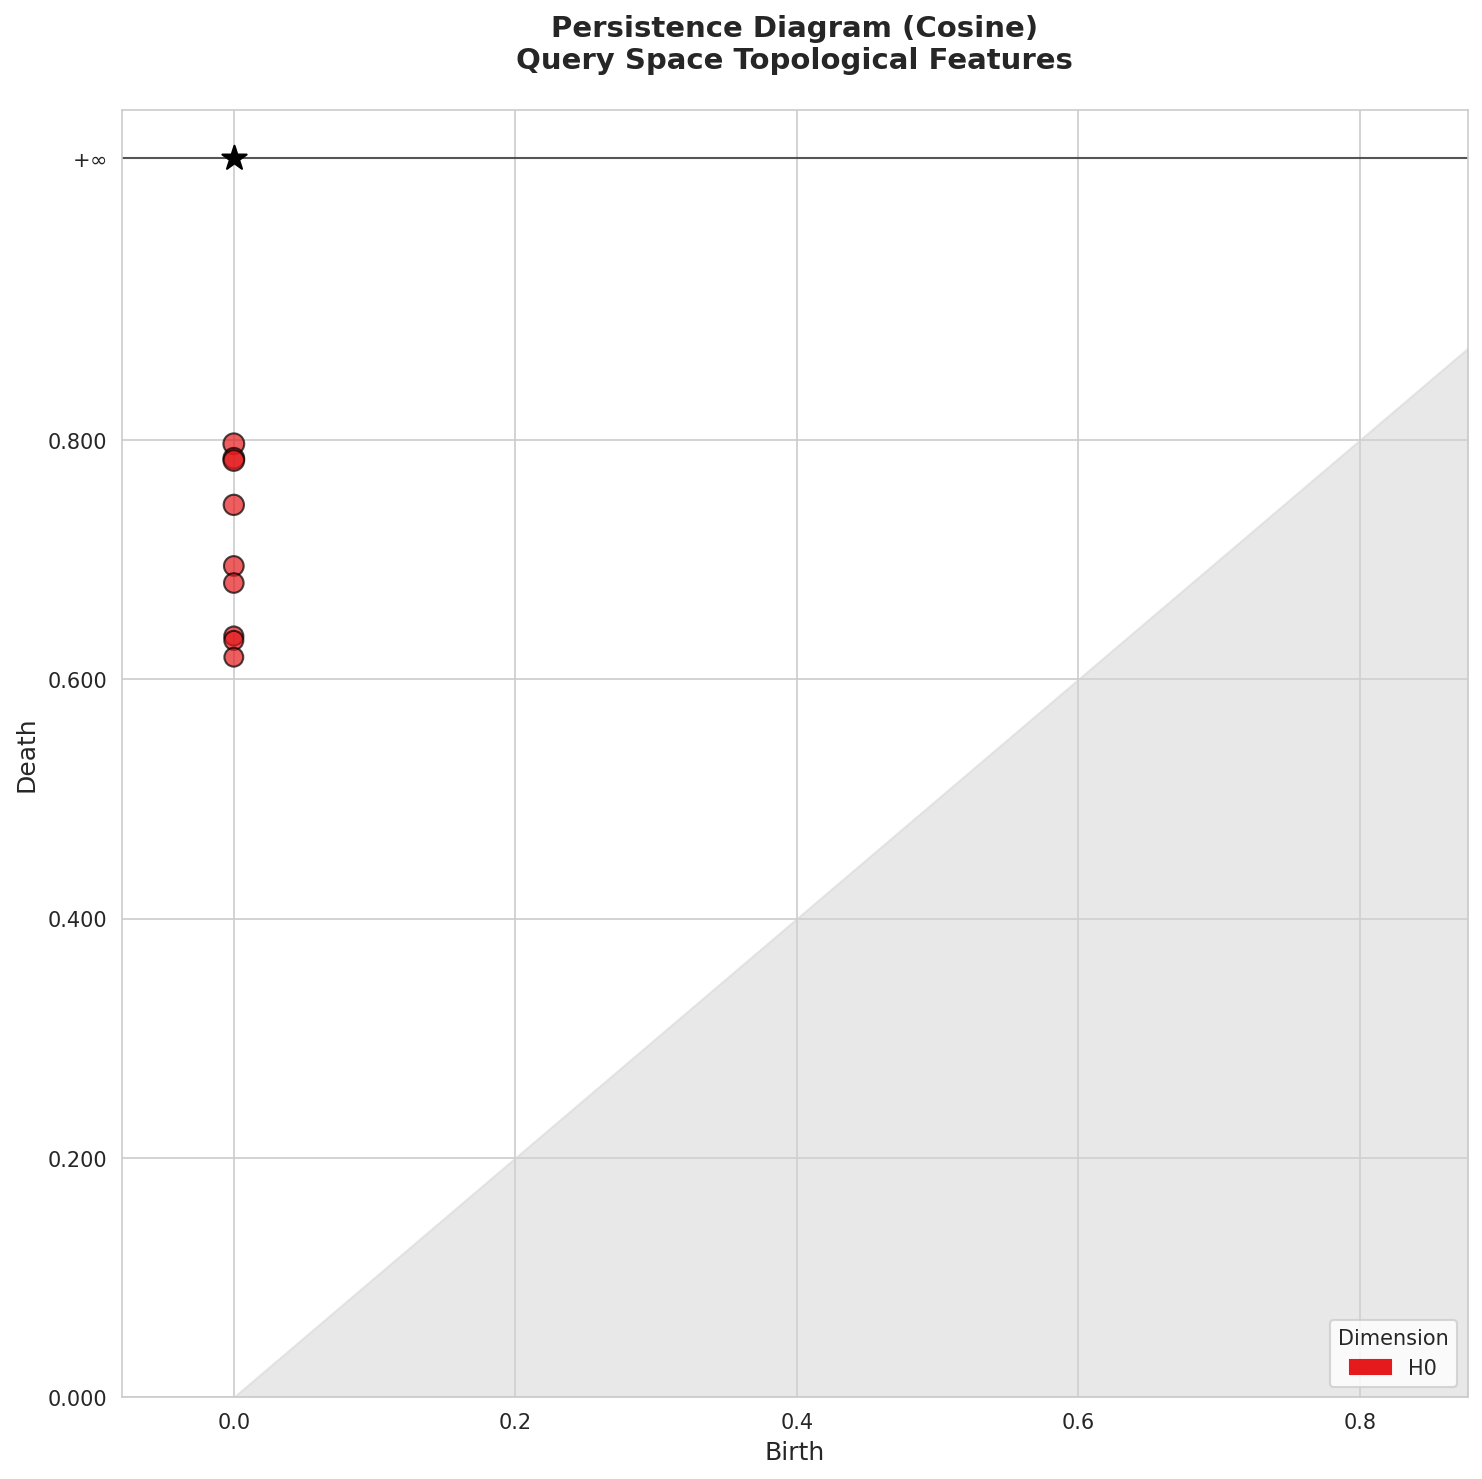


persistence_diagram_euclidean.png


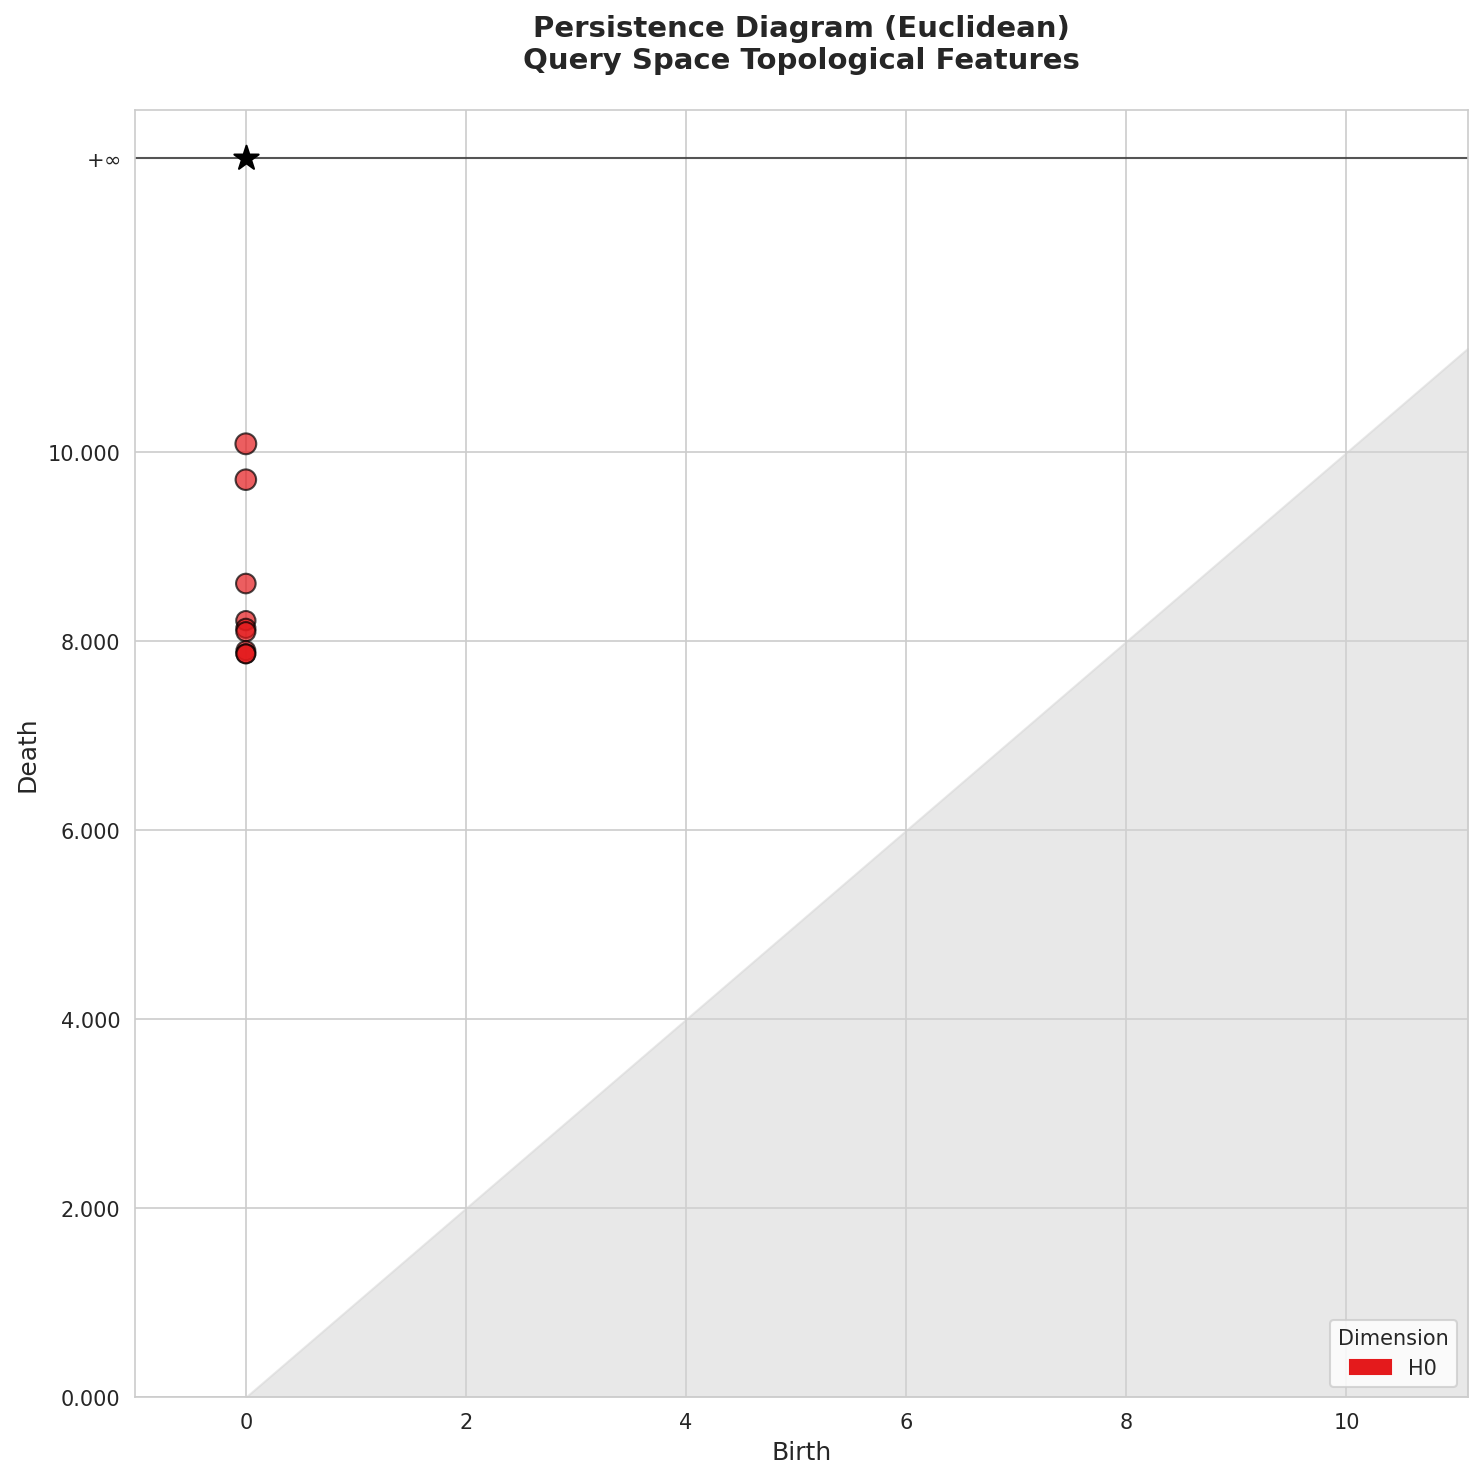


persistence_diagram_mahalanobis.png


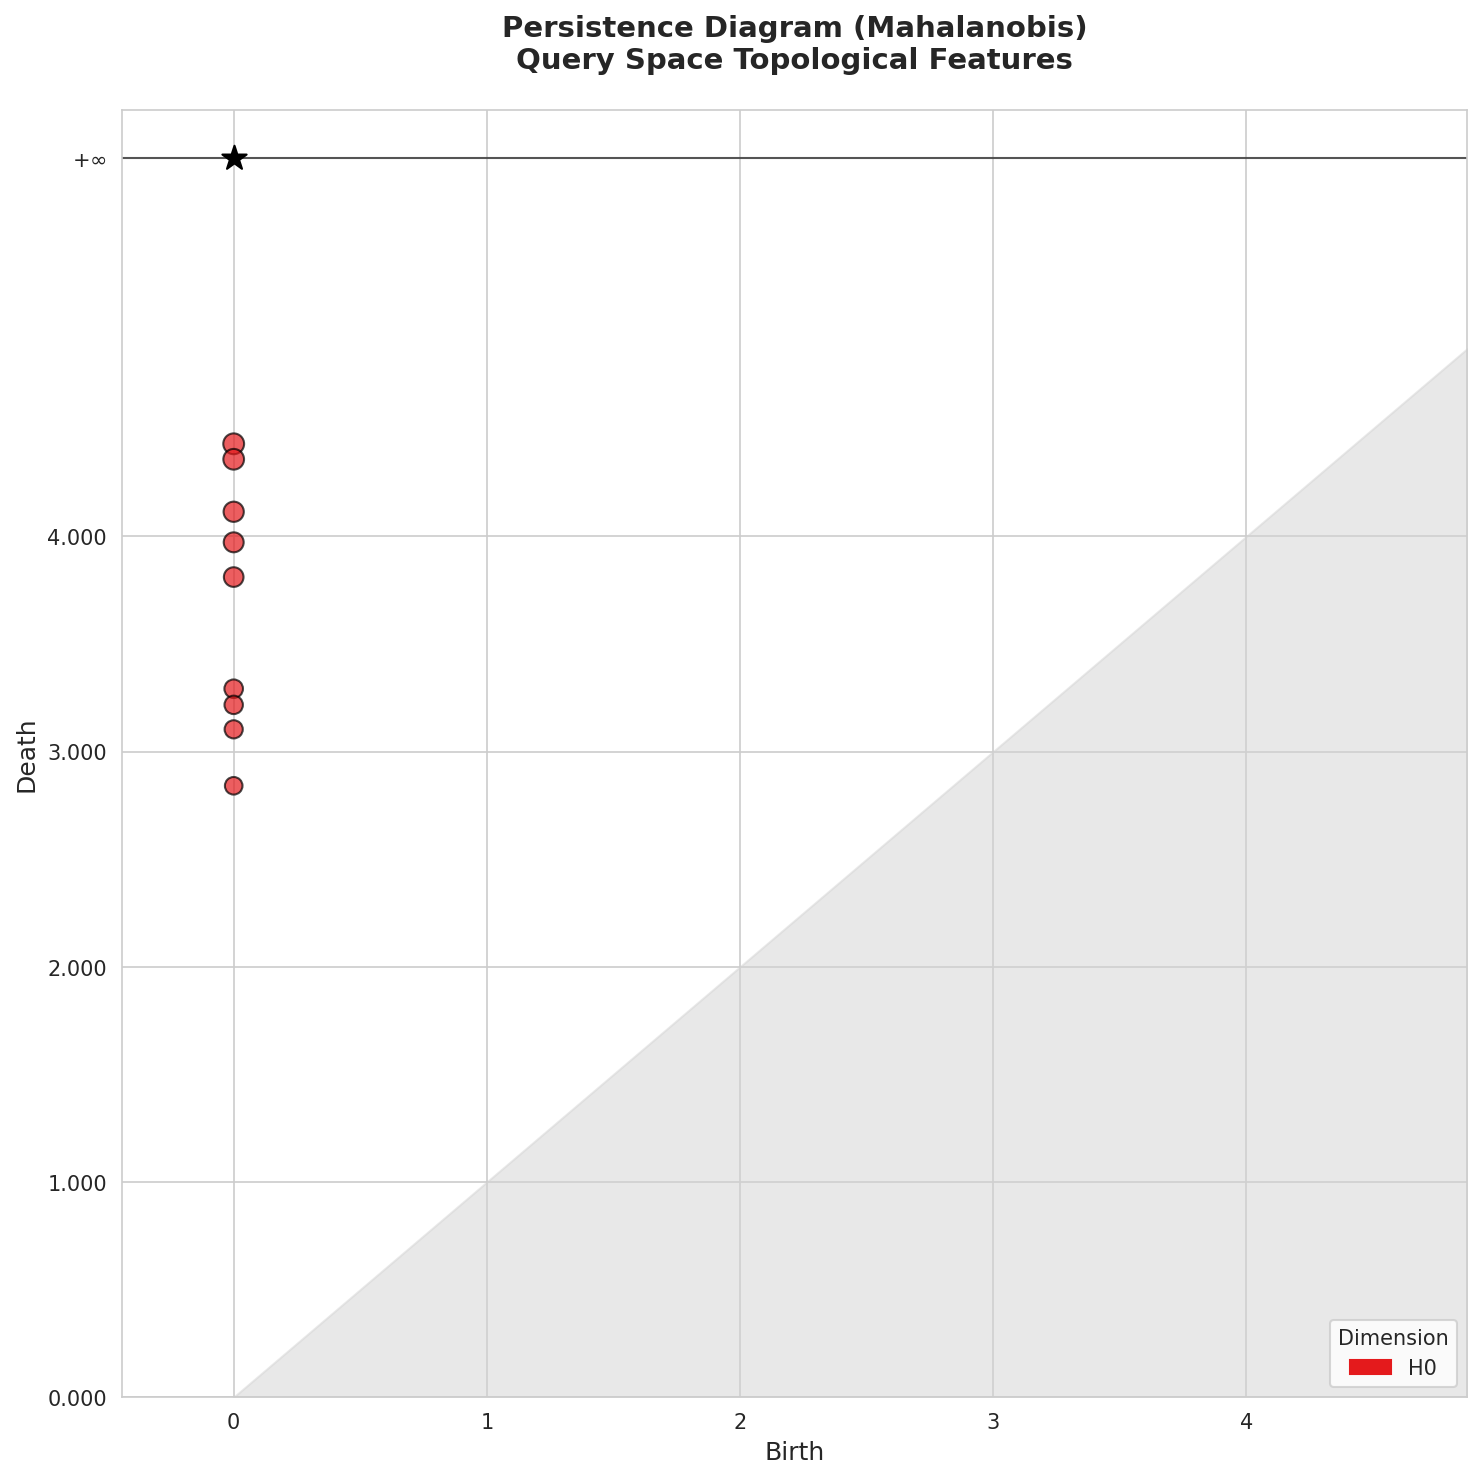


PERSISTENCE BARCODES - Show feature lifetimes

persistence_barcode_cosine.png


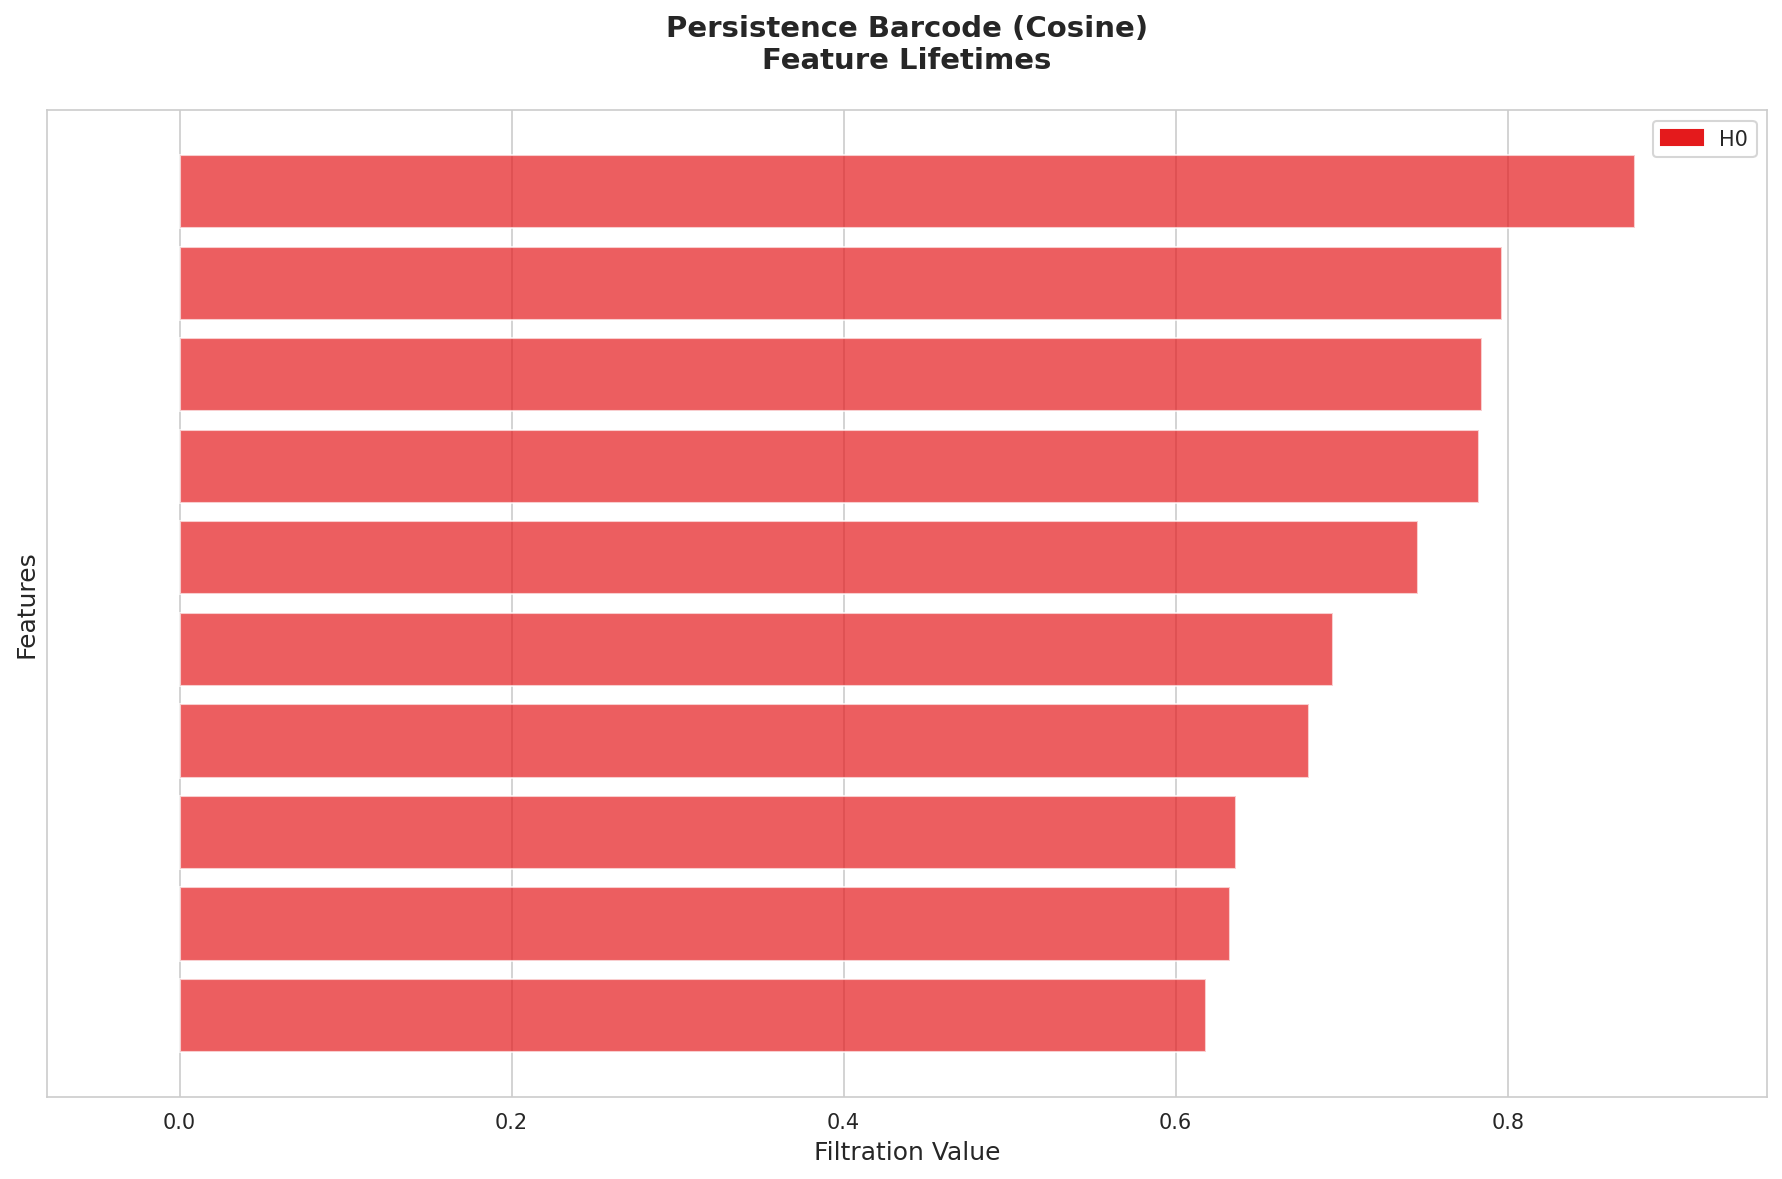


persistence_barcode_euclidean.png


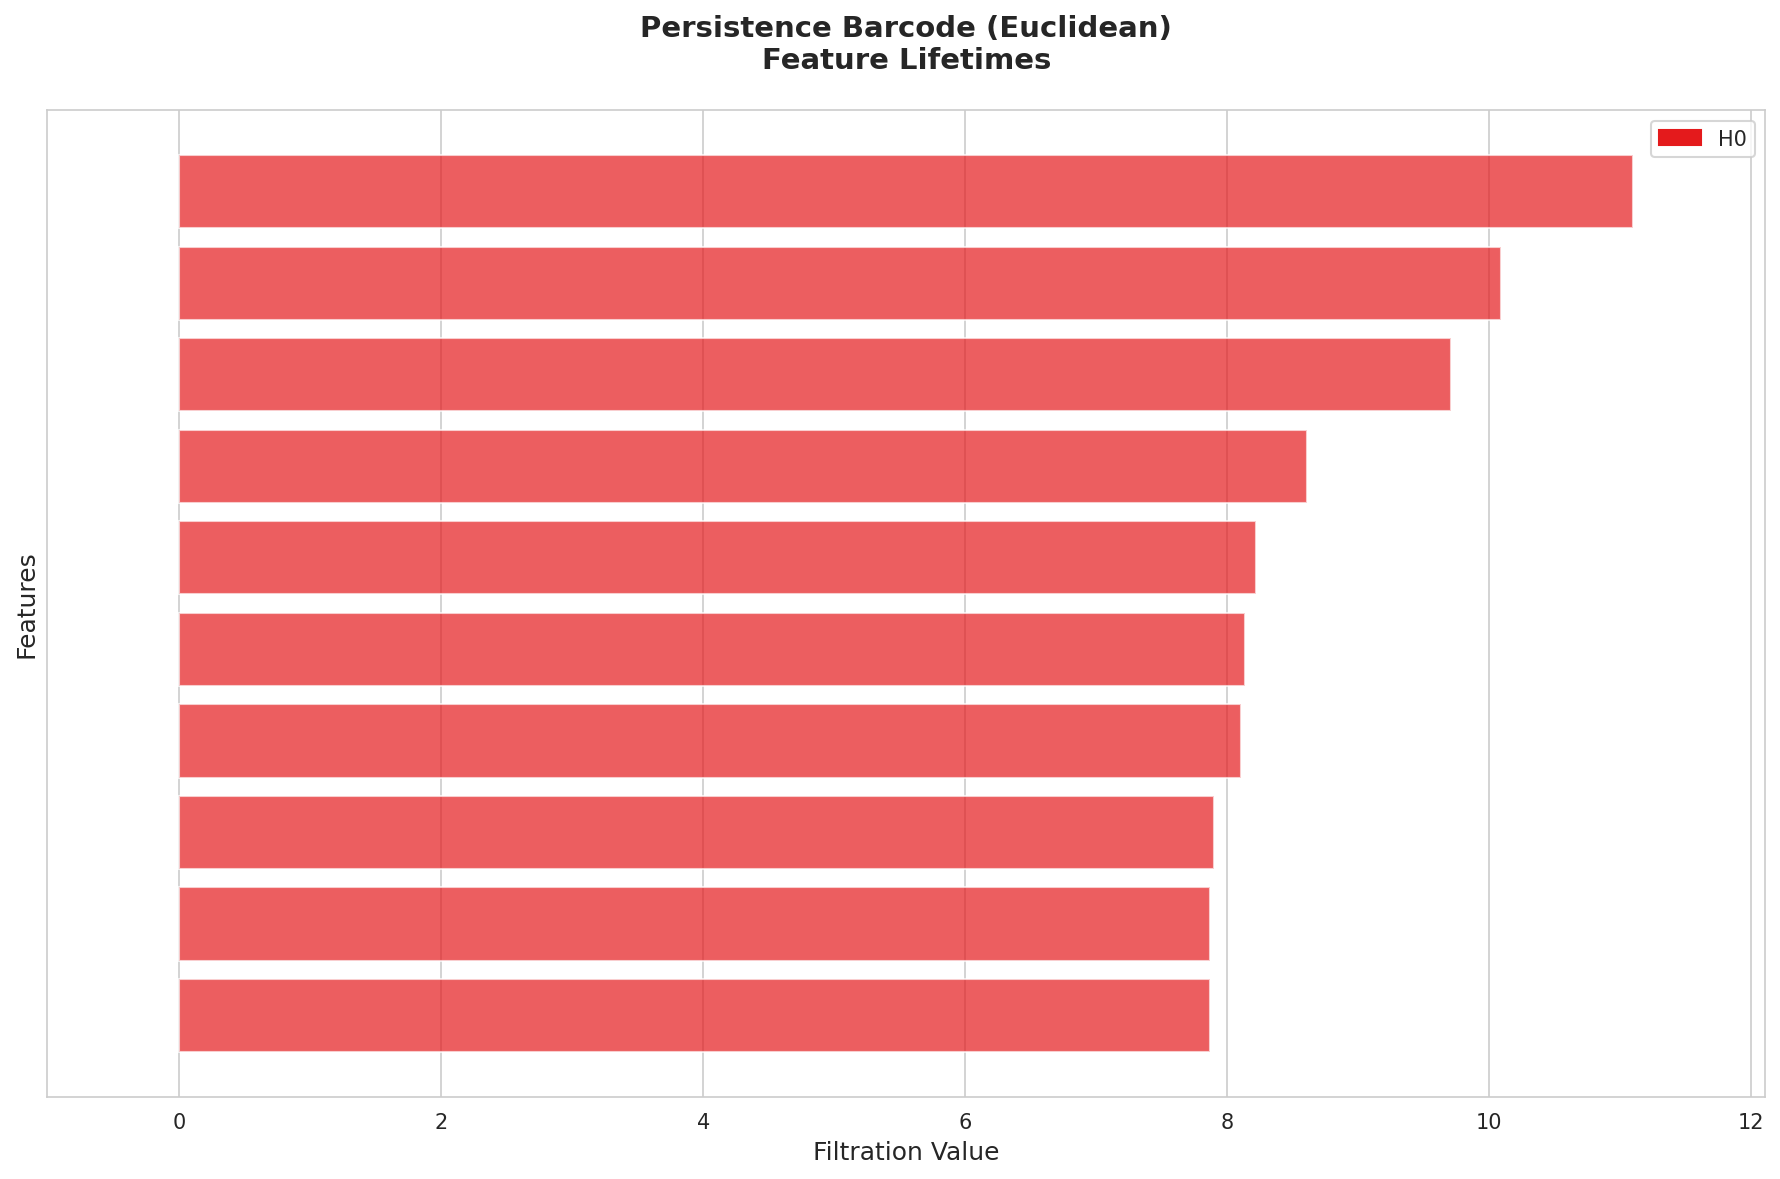


persistence_barcode_mahalanobis.png


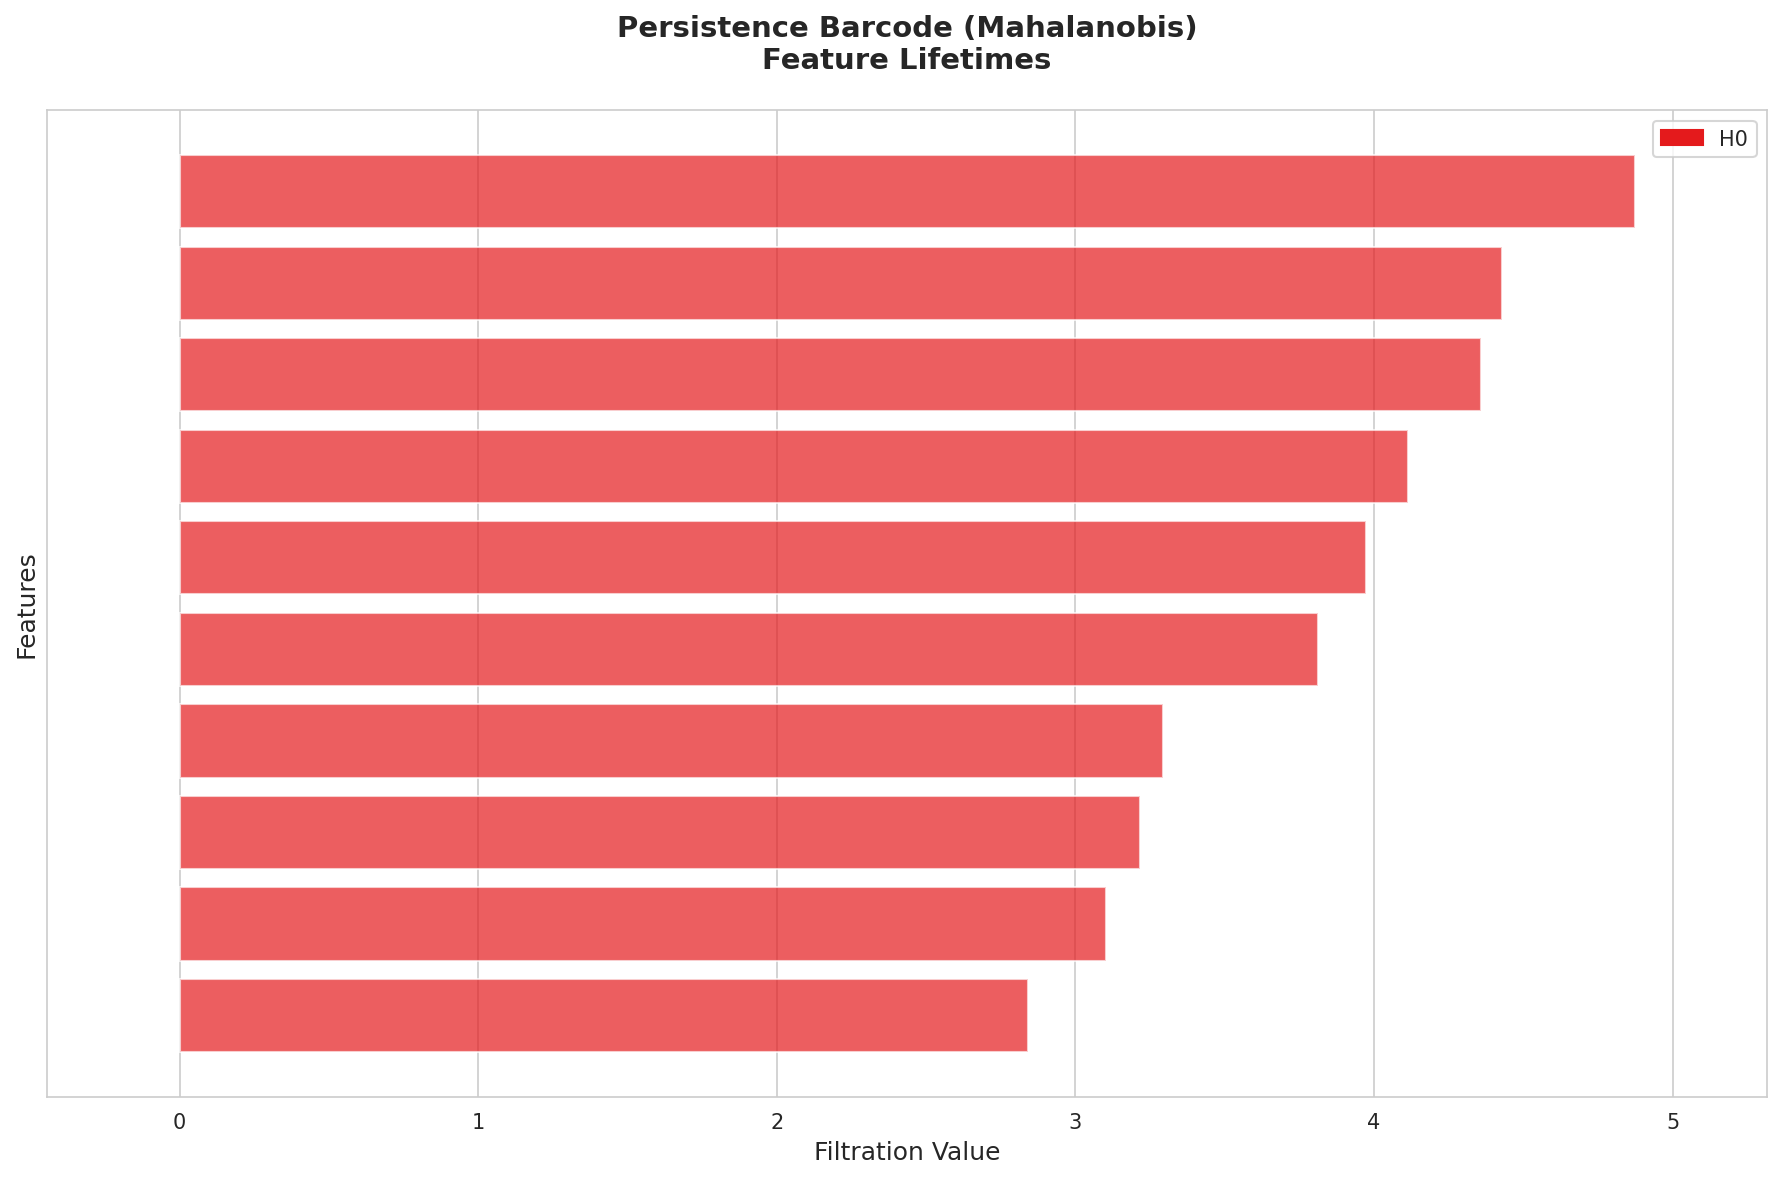


DISTANCE HEATMAPS - Show query similarity matrices

heatmap_cosine.png


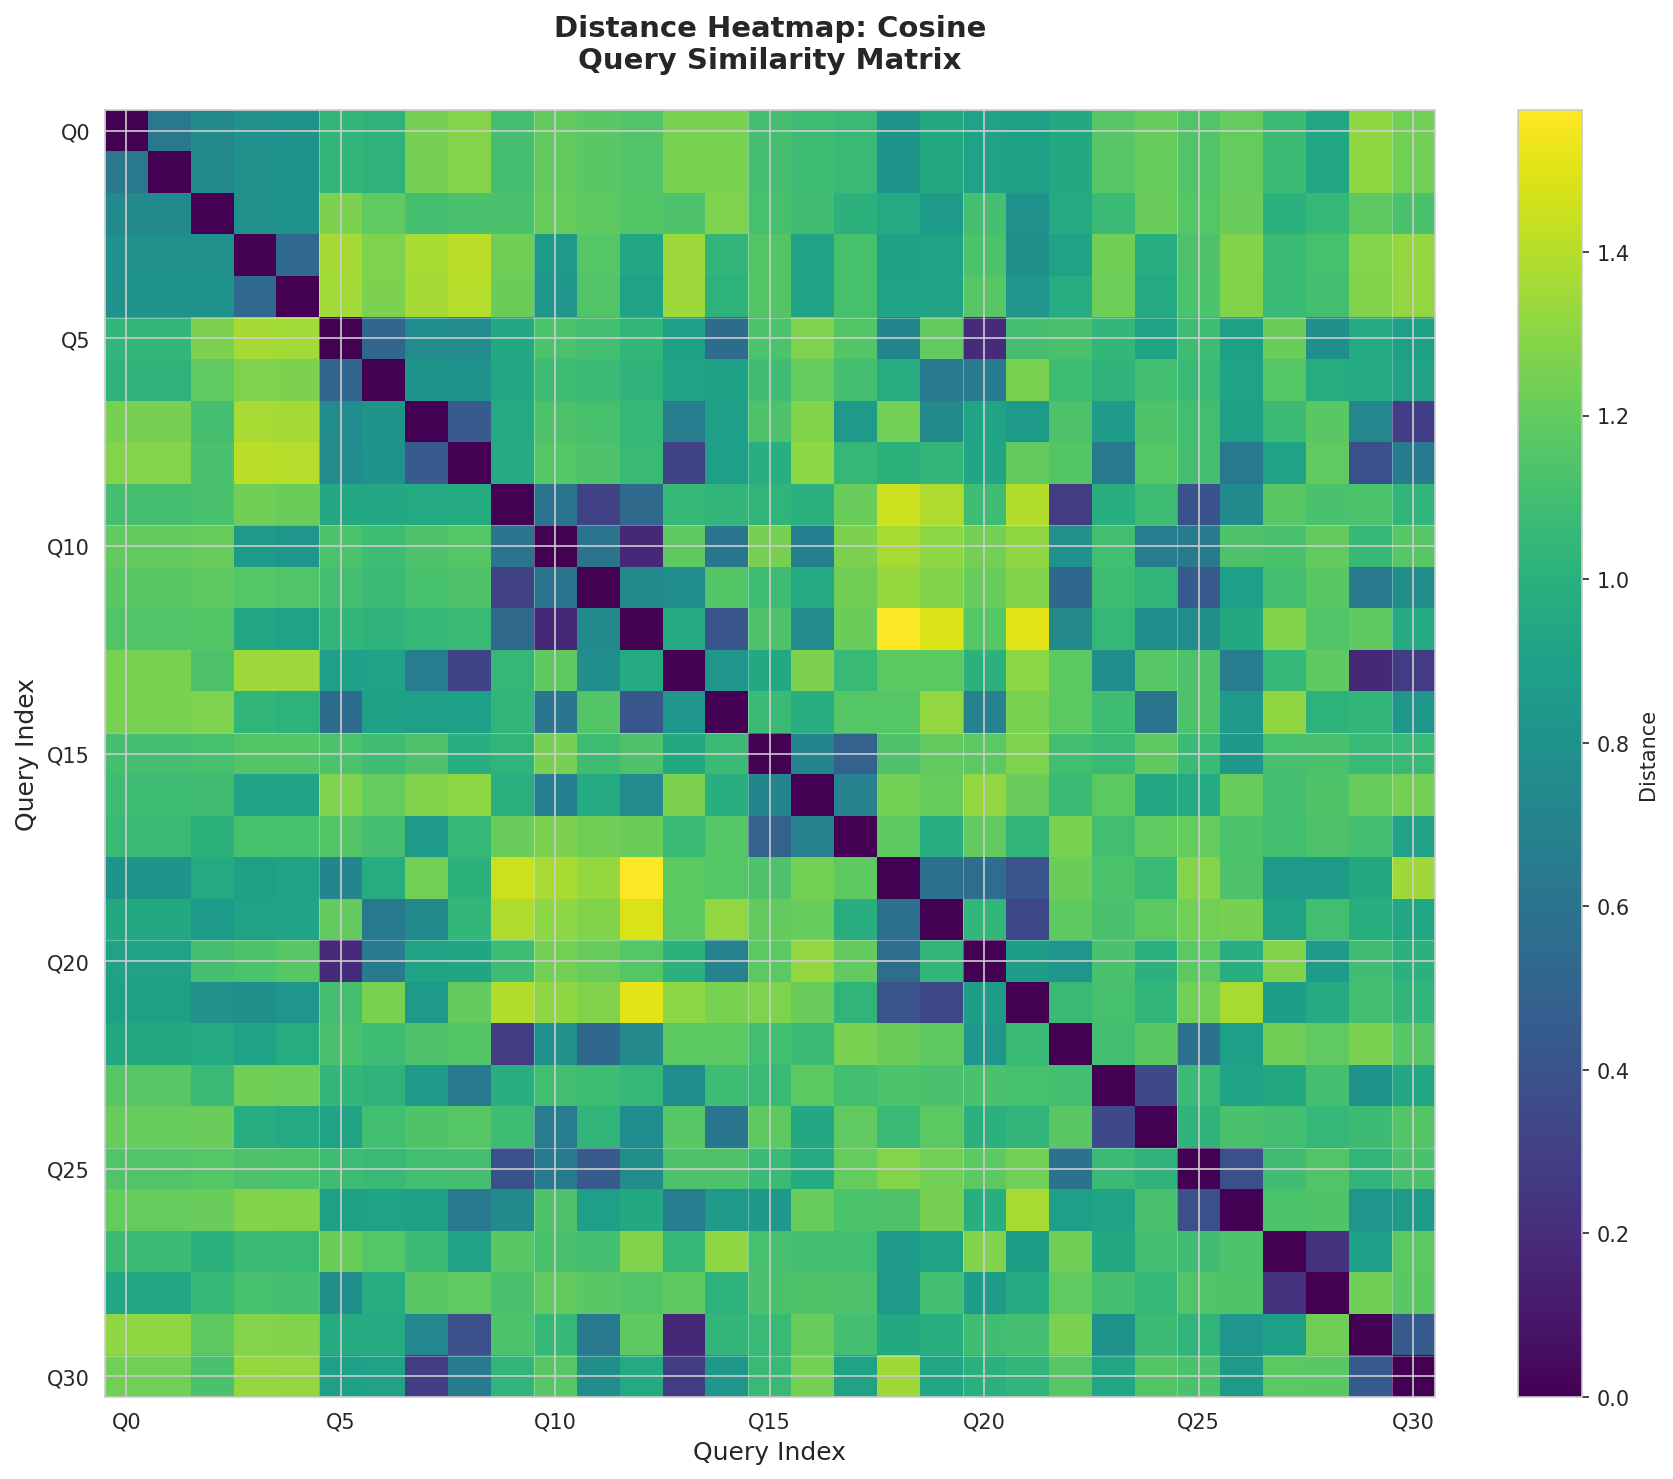


heatmap_euclidean.png


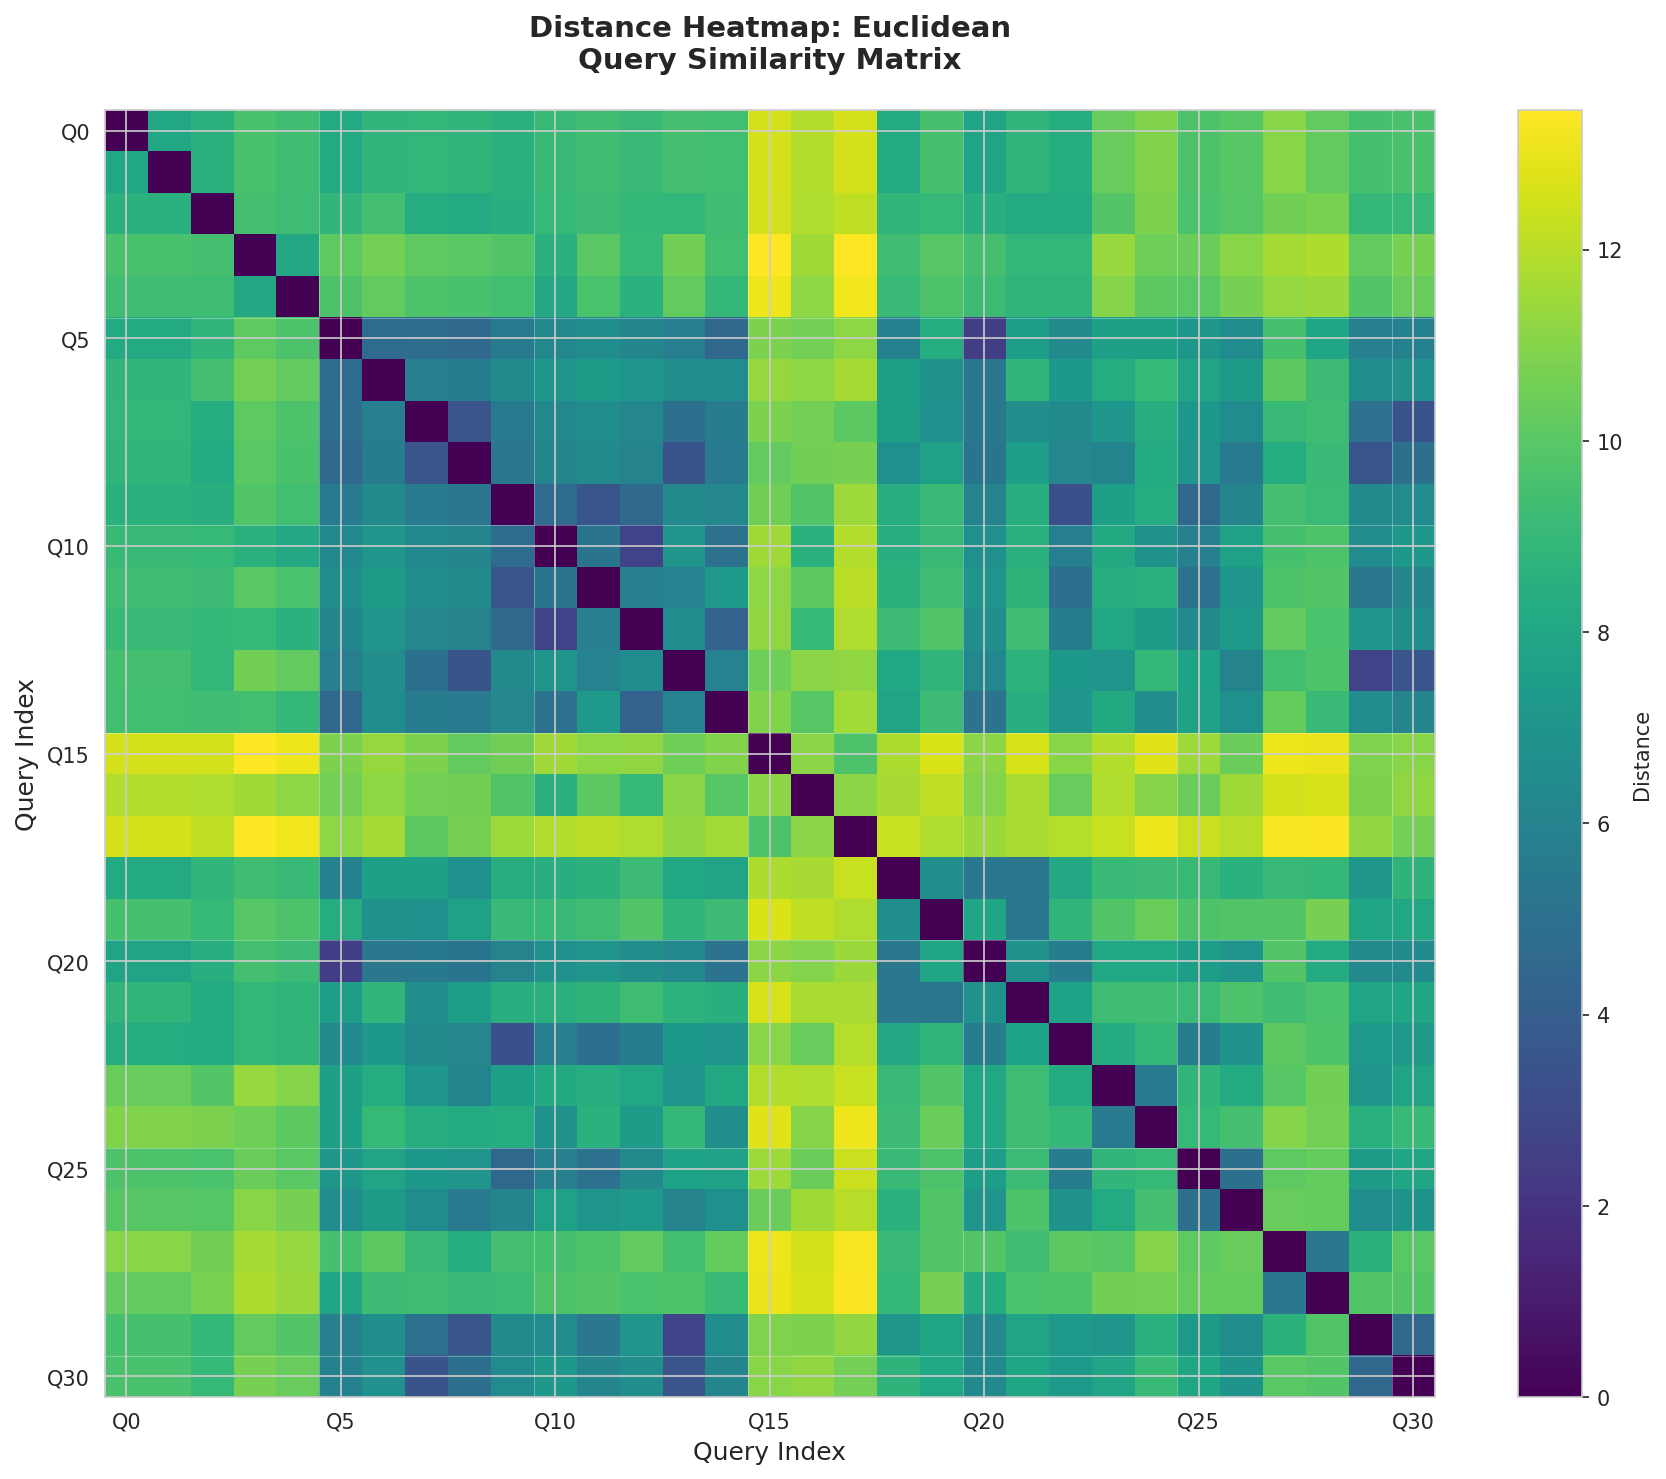


heatmap_mahalanobis.png


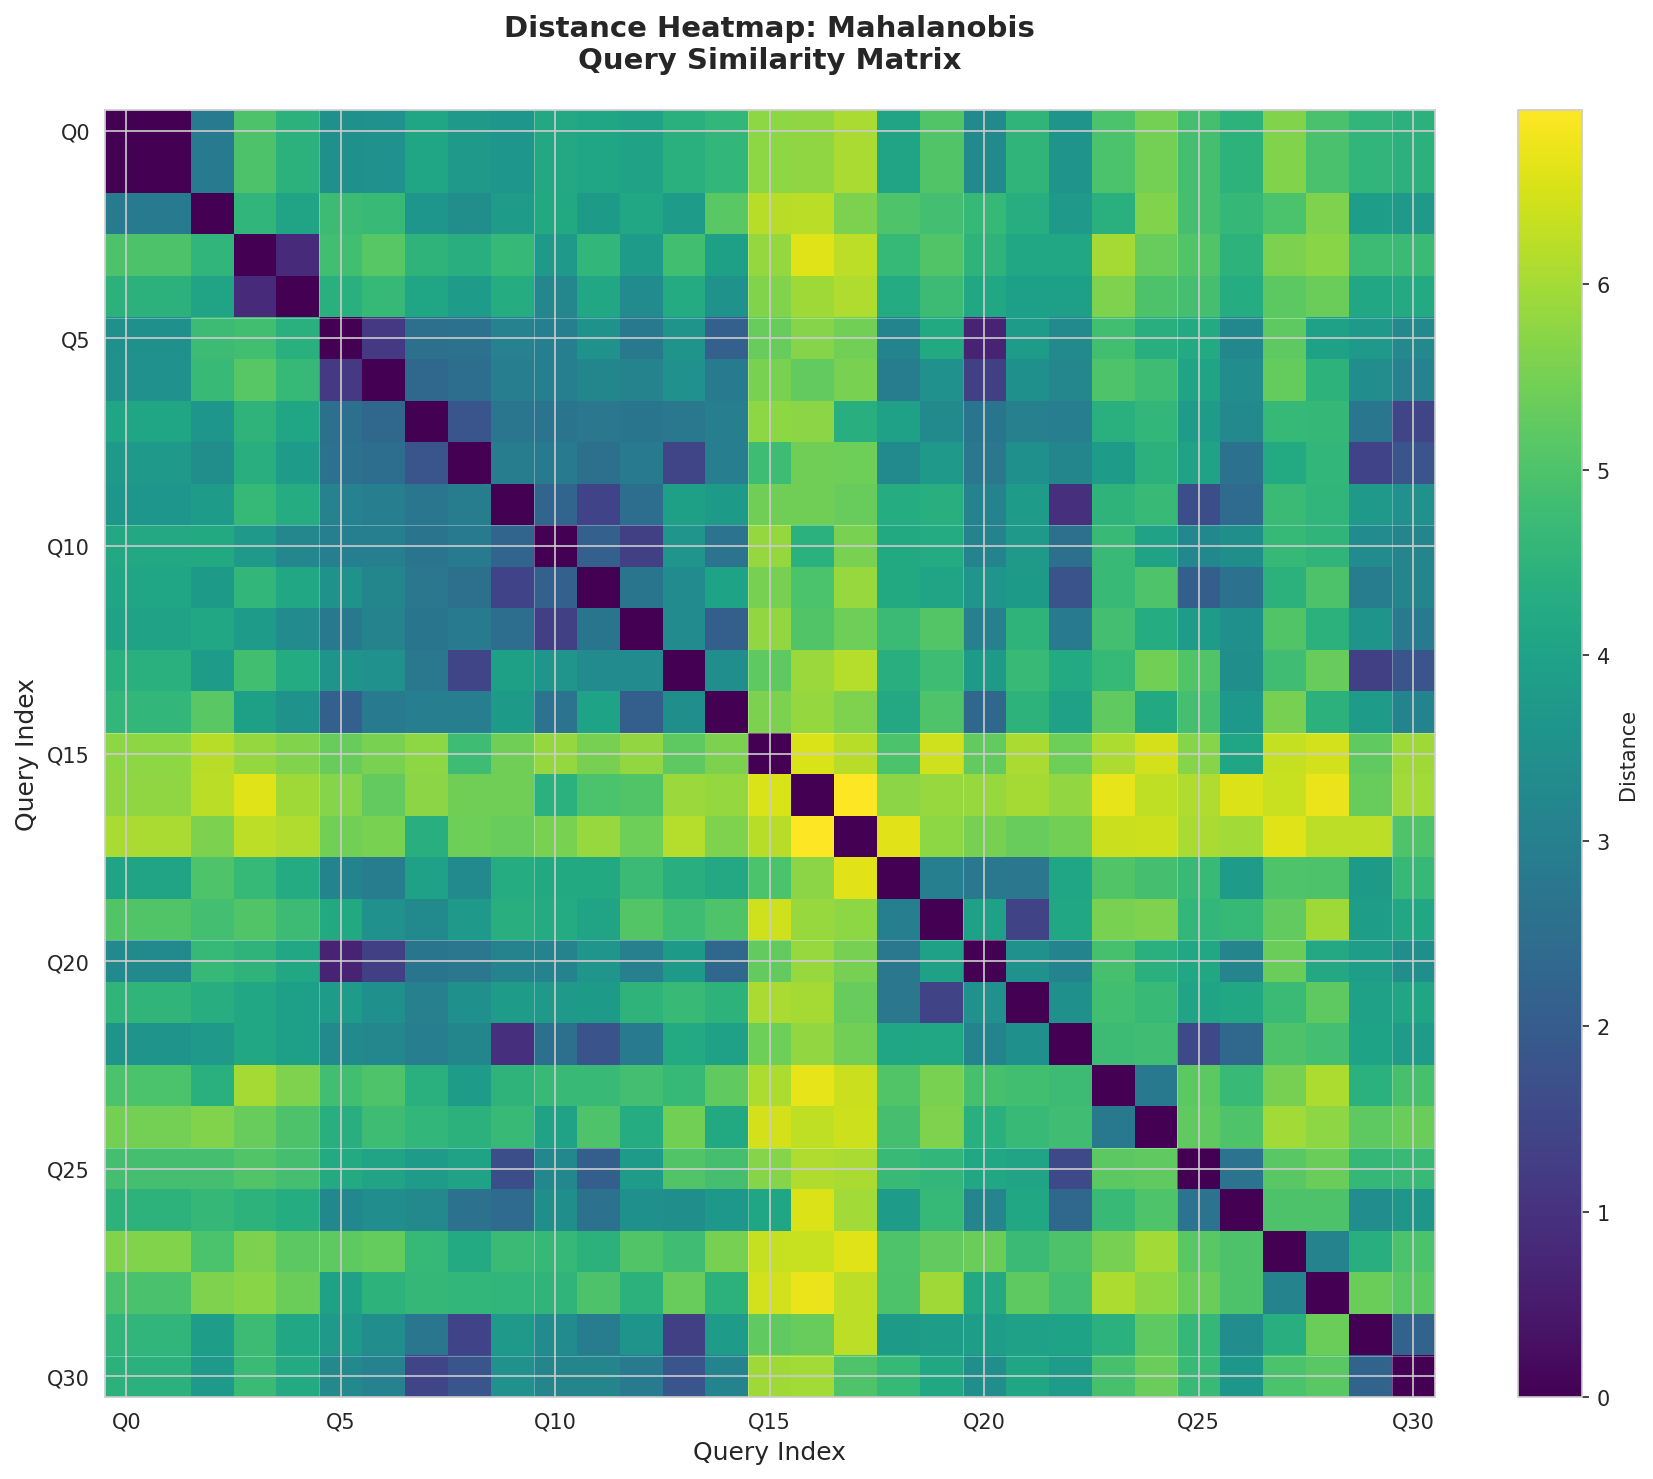


DIMENSIONALITY REDUCTION - Show query clusters in 2D

PCA Projection


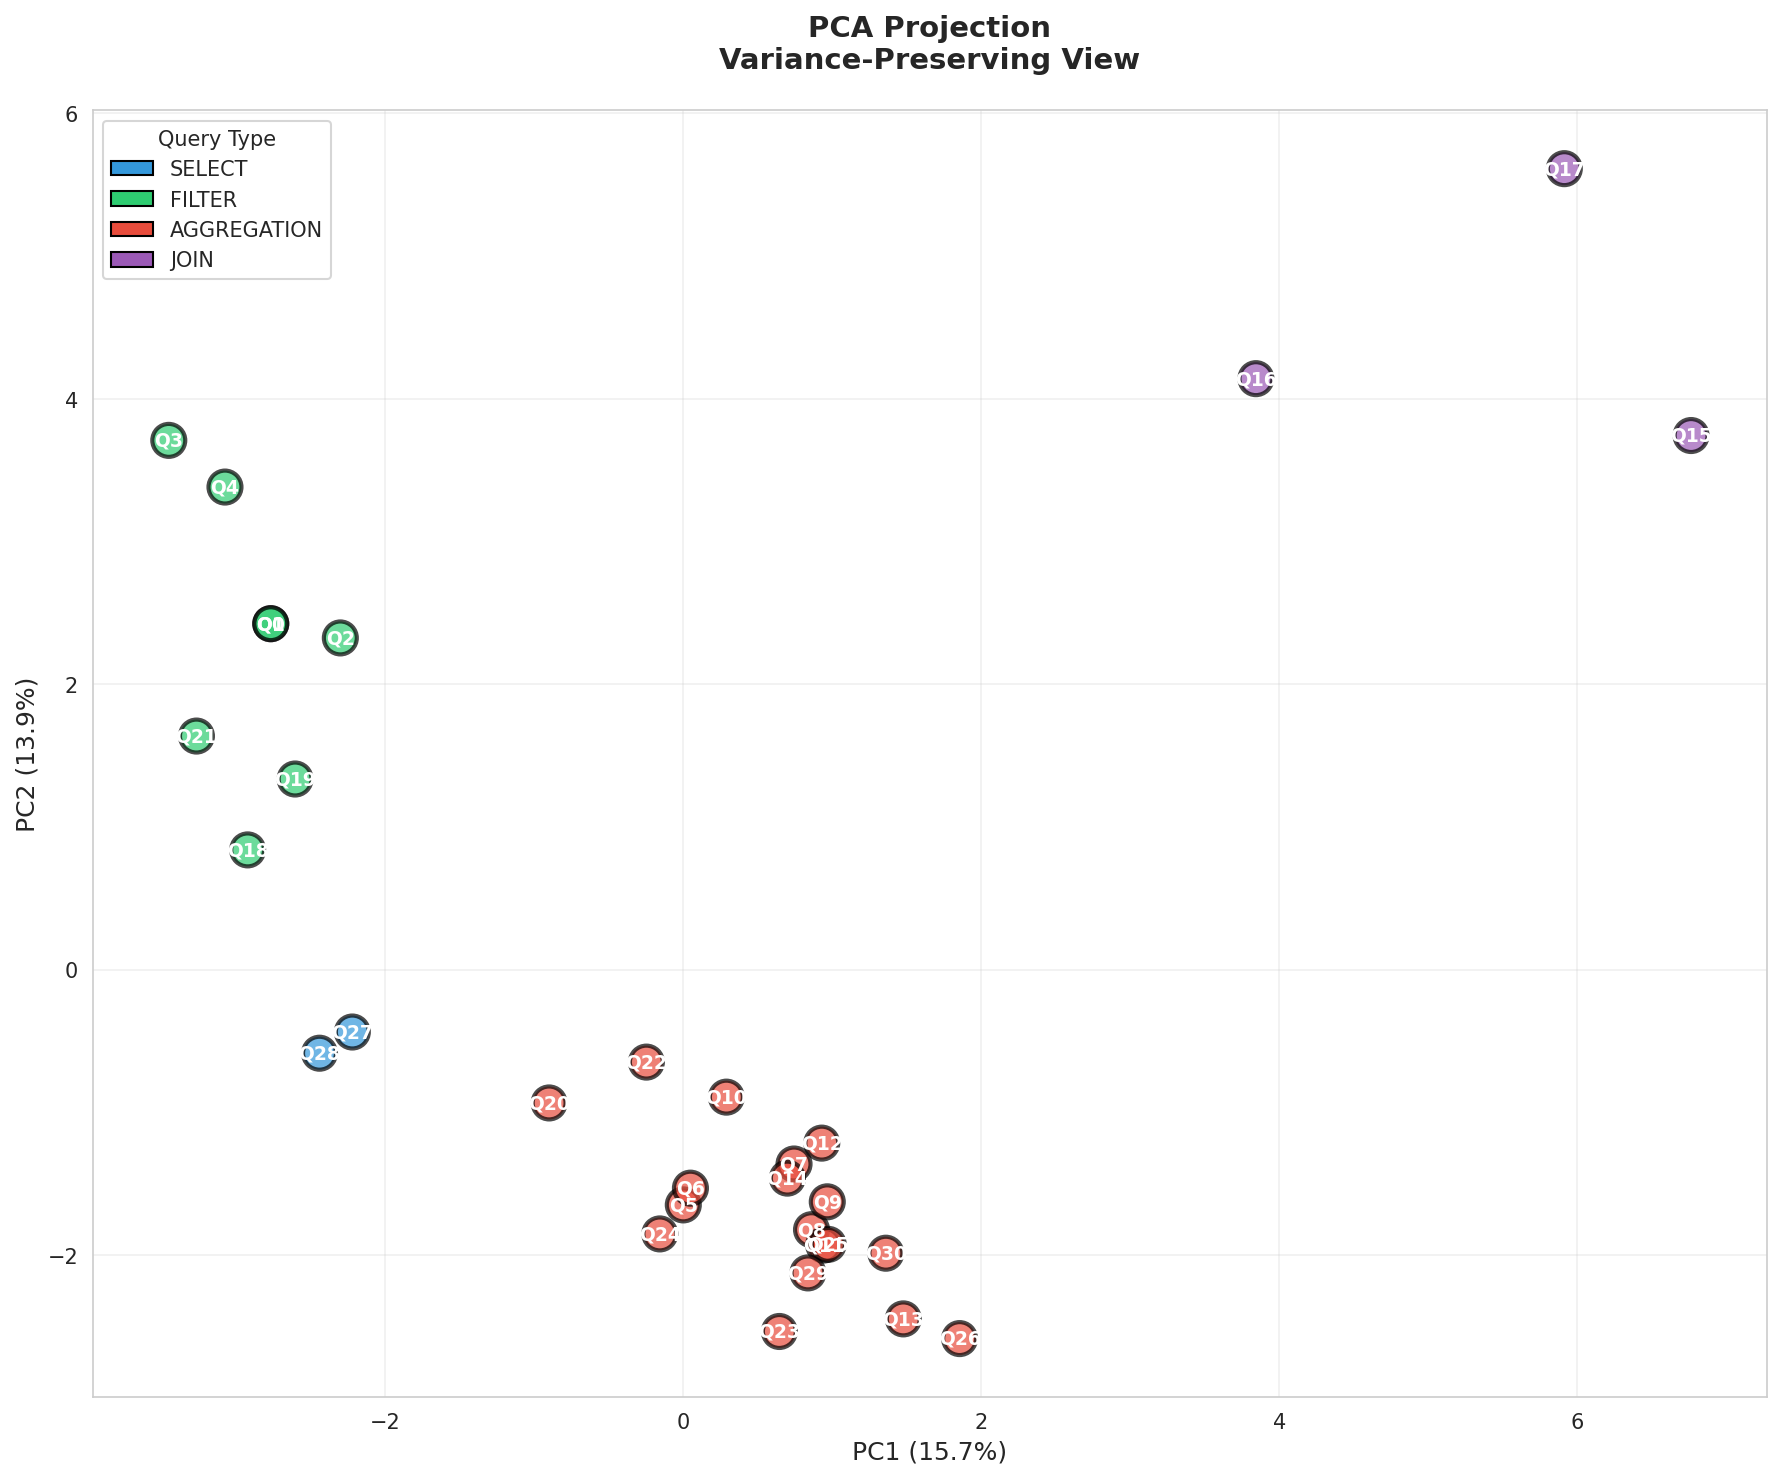


MDS Projections


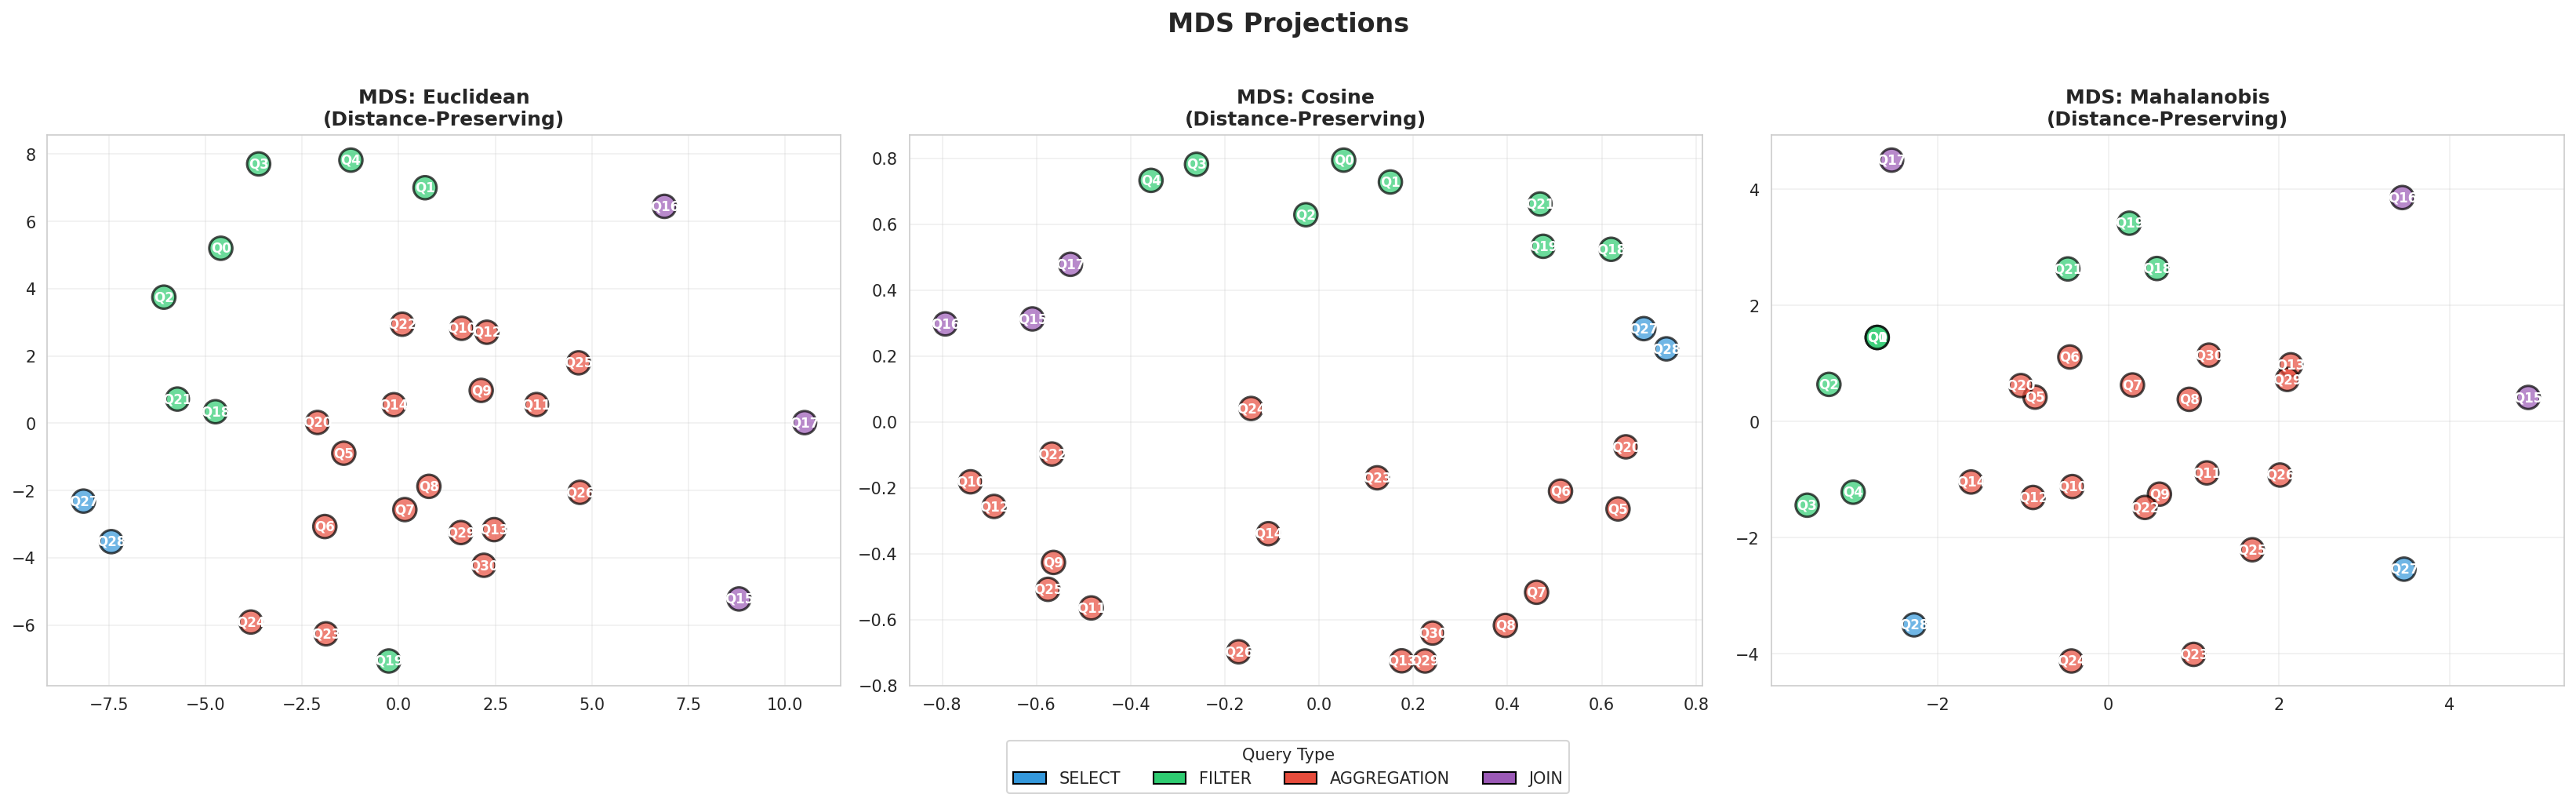

In [31]:
from IPython.display import Image, display
import glob

# Show key visualizations
viz_dir = 'outputs/visualizations'

print("PERSISTENCE DIAGRAMS - Show topological features in query space")
print("=" * 80)
for img in sorted(glob.glob(f'{viz_dir}/persistence_diagram_*.png')):
    print(f"\n{os.path.basename(img)}")
    display(Image(filename=img, width=600))

print("\nPERSISTENCE BARCODES - Show feature lifetimes")
print("=" * 80)
for img in sorted(glob.glob(f'{viz_dir}/persistence_barcode_*.png')):
    print(f"\n{os.path.basename(img)}")
    display(Image(filename=img, width=800))

print("\nDISTANCE HEATMAPS - Show query similarity matrices")
print("=" * 80)
for img in sorted(glob.glob(f'{viz_dir}/heatmap_*.png')):
    print(f"\n{os.path.basename(img)}")
    display(Image(filename=img, width=700))

print("\nDIMENSIONALITY REDUCTION - Show query clusters in 2D")
print("=" * 80)
print("\nPCA Projection")
display(Image(filename=f'{viz_dir}/pca_projection.png', width=700))

print("\nMDS Projections")
display(Image(filename=f'{viz_dir}/mds_projections.png', width=900))
